### Dataset Sources

Beat Acute Myeloid Leukemia (AML) 1.0 was accessed on 13Mar2023 from https://registry.opendata.aws/beataml. OHSU BeatAML Datasets Link: https://ctd2-data.nci.nih.gov/Public/OHSU-1/BeatAML_Waves1_2/

OpenCell Datasets Link: https://opencell.czbiohub.org/download

### Dataset S3 Location

Importing Raw Datasets from AWS S3. Use the AWS Command Line Interface (CLI) to list the S3 bucket content using the following CLI commands:

In [87]:
!aws s3 ls s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/

2023-03-21 02:37:21          0 
2023-03-27 02:40:07     714614 OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.txt


In [88]:
!aws s3 ls s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/

2023-03-21 02:37:38          0 
2023-03-21 02:38:40    4568928 opencell-protein-interactions.csv


### Check Pre-Requisites from the `01_setup/` Folder

In [89]:
%store -r setup_instance_check_passed

In [90]:
try:
    setup_instance_check_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++")

In [91]:
print(setup_instance_check_passed)

True


In [92]:
%store -r setup_dependencies_passed

In [93]:
try:
    setup_dependencies_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++")

In [94]:
print(setup_dependencies_passed)

True


In [95]:
%store -r setup_s3_bucket_passed

In [96]:
try:
    setup_s3_bucket_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++")

In [97]:
print(setup_s3_bucket_passed)

True


In [98]:
%store -r setup_iam_roles_passed

In [99]:
try:
    setup_iam_roles_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++")

In [100]:
print(setup_iam_roles_passed)

True


In [101]:
if not setup_instance_check_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_dependencies_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_s3_bucket_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_iam_roles_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

In [102]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

### Set S3 Source Location

In [103]:
#BeatAML Clinical Summary
s3_public_path_clsm = "s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/"

In [104]:
%store s3_public_path_clsm

Stored 's3_public_path_clsm' (str)


In [105]:
print(s3_public_path_clsm)

s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/


In [106]:
!aws s3 ls $s3_public_path_clsm

2023-03-21 02:37:21          0 
2023-03-27 02:40:07     714614 OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.txt


In [107]:
#BeatAML OpenCell Protein Interaction
s3_public_path_pi = "s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/"

In [108]:
%store s3_public_path_pi

Stored 's3_public_path_pi' (str)


In [109]:
print(s3_public_path_pi)

s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/


In [110]:
!aws s3 ls $s3_public_path_pi

2023-03-21 02:37:38          0 
2023-03-21 02:38:40    4568928 opencell-protein-interactions.csv


In [111]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/team4rawdatasets?prefix=CSV/Input/&region=us-east-1">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

### Athena Database

[PyAthena](https://pypi.org/project/PyAthena/) is a Python DB API 2.0 (PEP 249) compliant client for Amazon Athena.

In [112]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [113]:
ingest_create_athena_db_passed = False

In [114]:
database_name = "bcr"

In [115]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [116]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [117]:
statement0 = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement0)

CREATE DATABASE IF NOT EXISTS bcr


In [118]:
pd.read_sql(statement0, conn)

Empty DataFrame
Columns: []
Index: []

### Verify The Database Has Been Created Succesfully

In [119]:
statement00 = "SHOW DATABASES"

df_show = pd.read_sql(statement00, conn)
df_show.head(5)

database_name
0                     bcr
1                 default
2                  dsoaws
3  sagemaker_featurestore

In [120]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [121]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


### Athena Table Created Through AWS Glue Crawler

In [122]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="top" href="https://us-east-1.console.aws.amazon.com/glue/home?region=us-east-1#/v2/data-catalog/tables">AWS Glue Catalog</a></b>'.format(
            region
        )
    )
)

### Athena Sample Query

In [123]:
# Set Athena database & table
table_clsm = "ohsu_beataml_clinicalsummary"
table_pi = "opencell_proteininteraction"

In [124]:
#Athena SQL Code
statement1 = """
SELECT *
FROM {}.{} 
""".format(
    database_name, table_pi
)

print(statement1)


SELECT *
FROM bcr.opencell_proteininteraction 



In [125]:
pi = pd.read_sql(statement1, conn)
pi.head(5)

target_gene_name interactor_gene_name   target_ensg_id interactor_ensg_id  \
0             AAMP               ARGLU1  ENSG00000127837    ENSG00000134884   
1             AAMP              CWF19L2  ENSG00000127837    ENSG00000152404   
2             AAMP              PRPF40A  ENSG00000127837    ENSG00000196504   
3             AAMP                RPL10  ENSG00000127837    ENSG00000147403   
4             AAMP                RSRC1  ENSG00000127837    ENSG00000174891   

                              interactor_uniprot_ids       pval  enrichment  \
0                           Q9NWB6;Q9NWB6-3;Q9NWB6-2   5.495914    2.868131   
1             Q2TBE0;Q2TBE0-2;H7C3G7;Q2TBE0-3;H0YE03   5.480125    2.889502   
2  A0A3F2YNY6;O75400-2;O75400-3;O75400;H0YG38;F5H578   5.321102    3.228531   
3                 X1WI28;P27635;B8A6G2;A6QRI9;Q96L21  15.156173    4.847218   
4  Q96IZ7-2;Q96IZ7;H7C5Q0;C9J713;C9J367;C9J8Q2;C9...   5.929453    3.239392   

  interaction_stoichiometry abundance_stoichiometry  
0         0.128617729227485       0.222926886757708  
1        0.0220086333382949      0.0630363097469908  
2       0.00158221475294645        0.74201685528861  
3         0.521148076897205        13.1469097118672  
4        0.0131705143900265       0.210925681027771

In [126]:
if not pi.empty:
    print("[OK]")
else:
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOUR DATA HAS NOT BEEN CONVERTED TO PARQUET. LOOK IN PREVIOUS CELLS TO FIND THE ISSUE.")
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")

[OK]


# Data cleaning

### Import Tools: 

In [127]:
!pip install klib

In [128]:
import numpy as np
import seaborn as sns
import klib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

## BeatAML Clinical Summary

### OHSU BeatAML Clinical Summary Table

In [129]:
# SQL statement
statement2 = """
SELECT *
FROM {}.{} 
""".format(
    database_name, table_clsm
)

print(statement2)


SELECT *
FROM bcr.ohsu_beataml_clinicalsummary 



In [130]:
clsm = pd.read_sql(statement2, conn)
clsm.head(5)

labid  patientid consensus_sex inferred_sex inferred_ethnicity  \
0  09-00705        163          Male         Male              White   
1  10-00136        174          Male         Male              White   
2  10-00172        175        Female         Male              White   
3  10-00507         45        Female       Female              White   
4  10-00542        174          Male         Male              White   

   centerid cebpa_biallelic  ageatdiagnosis  isrelapse  isdenovo  ...  stag2  \
0         1               n            73.0      False      True  ...          
1         1               n            69.0      False      True  ...          
2         1               n            59.0      False      True  ...          
3         1               n            70.0      False      True  ...          
4         1               n            69.0       True     False  ...          

  stat3  suz12  tcl1a tet2 tp53 tyk2 u2af1 wt1 zrsr2  
0                                                     
1                                                     
2                                                     
3                                                     
4                                                     

[5 rows x 159 columns]

In [131]:
clsm = clsm.replace('', np.NAN)
clsm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Columns: 159 entries, labid to zrsr2
dtypes: bool(9), float64(22), int64(7), object(121)
memory usage: 793.5+ KB


In [132]:
clsm.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 159 columns):
 #    Column                                         Dtype  
---   ------                                         -----  
 0    labid                                          object 
 1    patientid                                      int64  
 2    consensus_sex                                  object 
 3    inferred_sex                                   object 
 4    inferred_ethnicity                             object 
 5    centerid                                       int64  
 6    cebpa_biallelic                                object 
 7    ageatdiagnosis                                 float64
 8    isrelapse                                      bool   
 9    isdenovo                                       bool   
 10   istransformed                                  bool   
 11   finalfusion                                    object 
 12   specificdxatacquisition_mdsmpn    

GridSpec(6, 6)

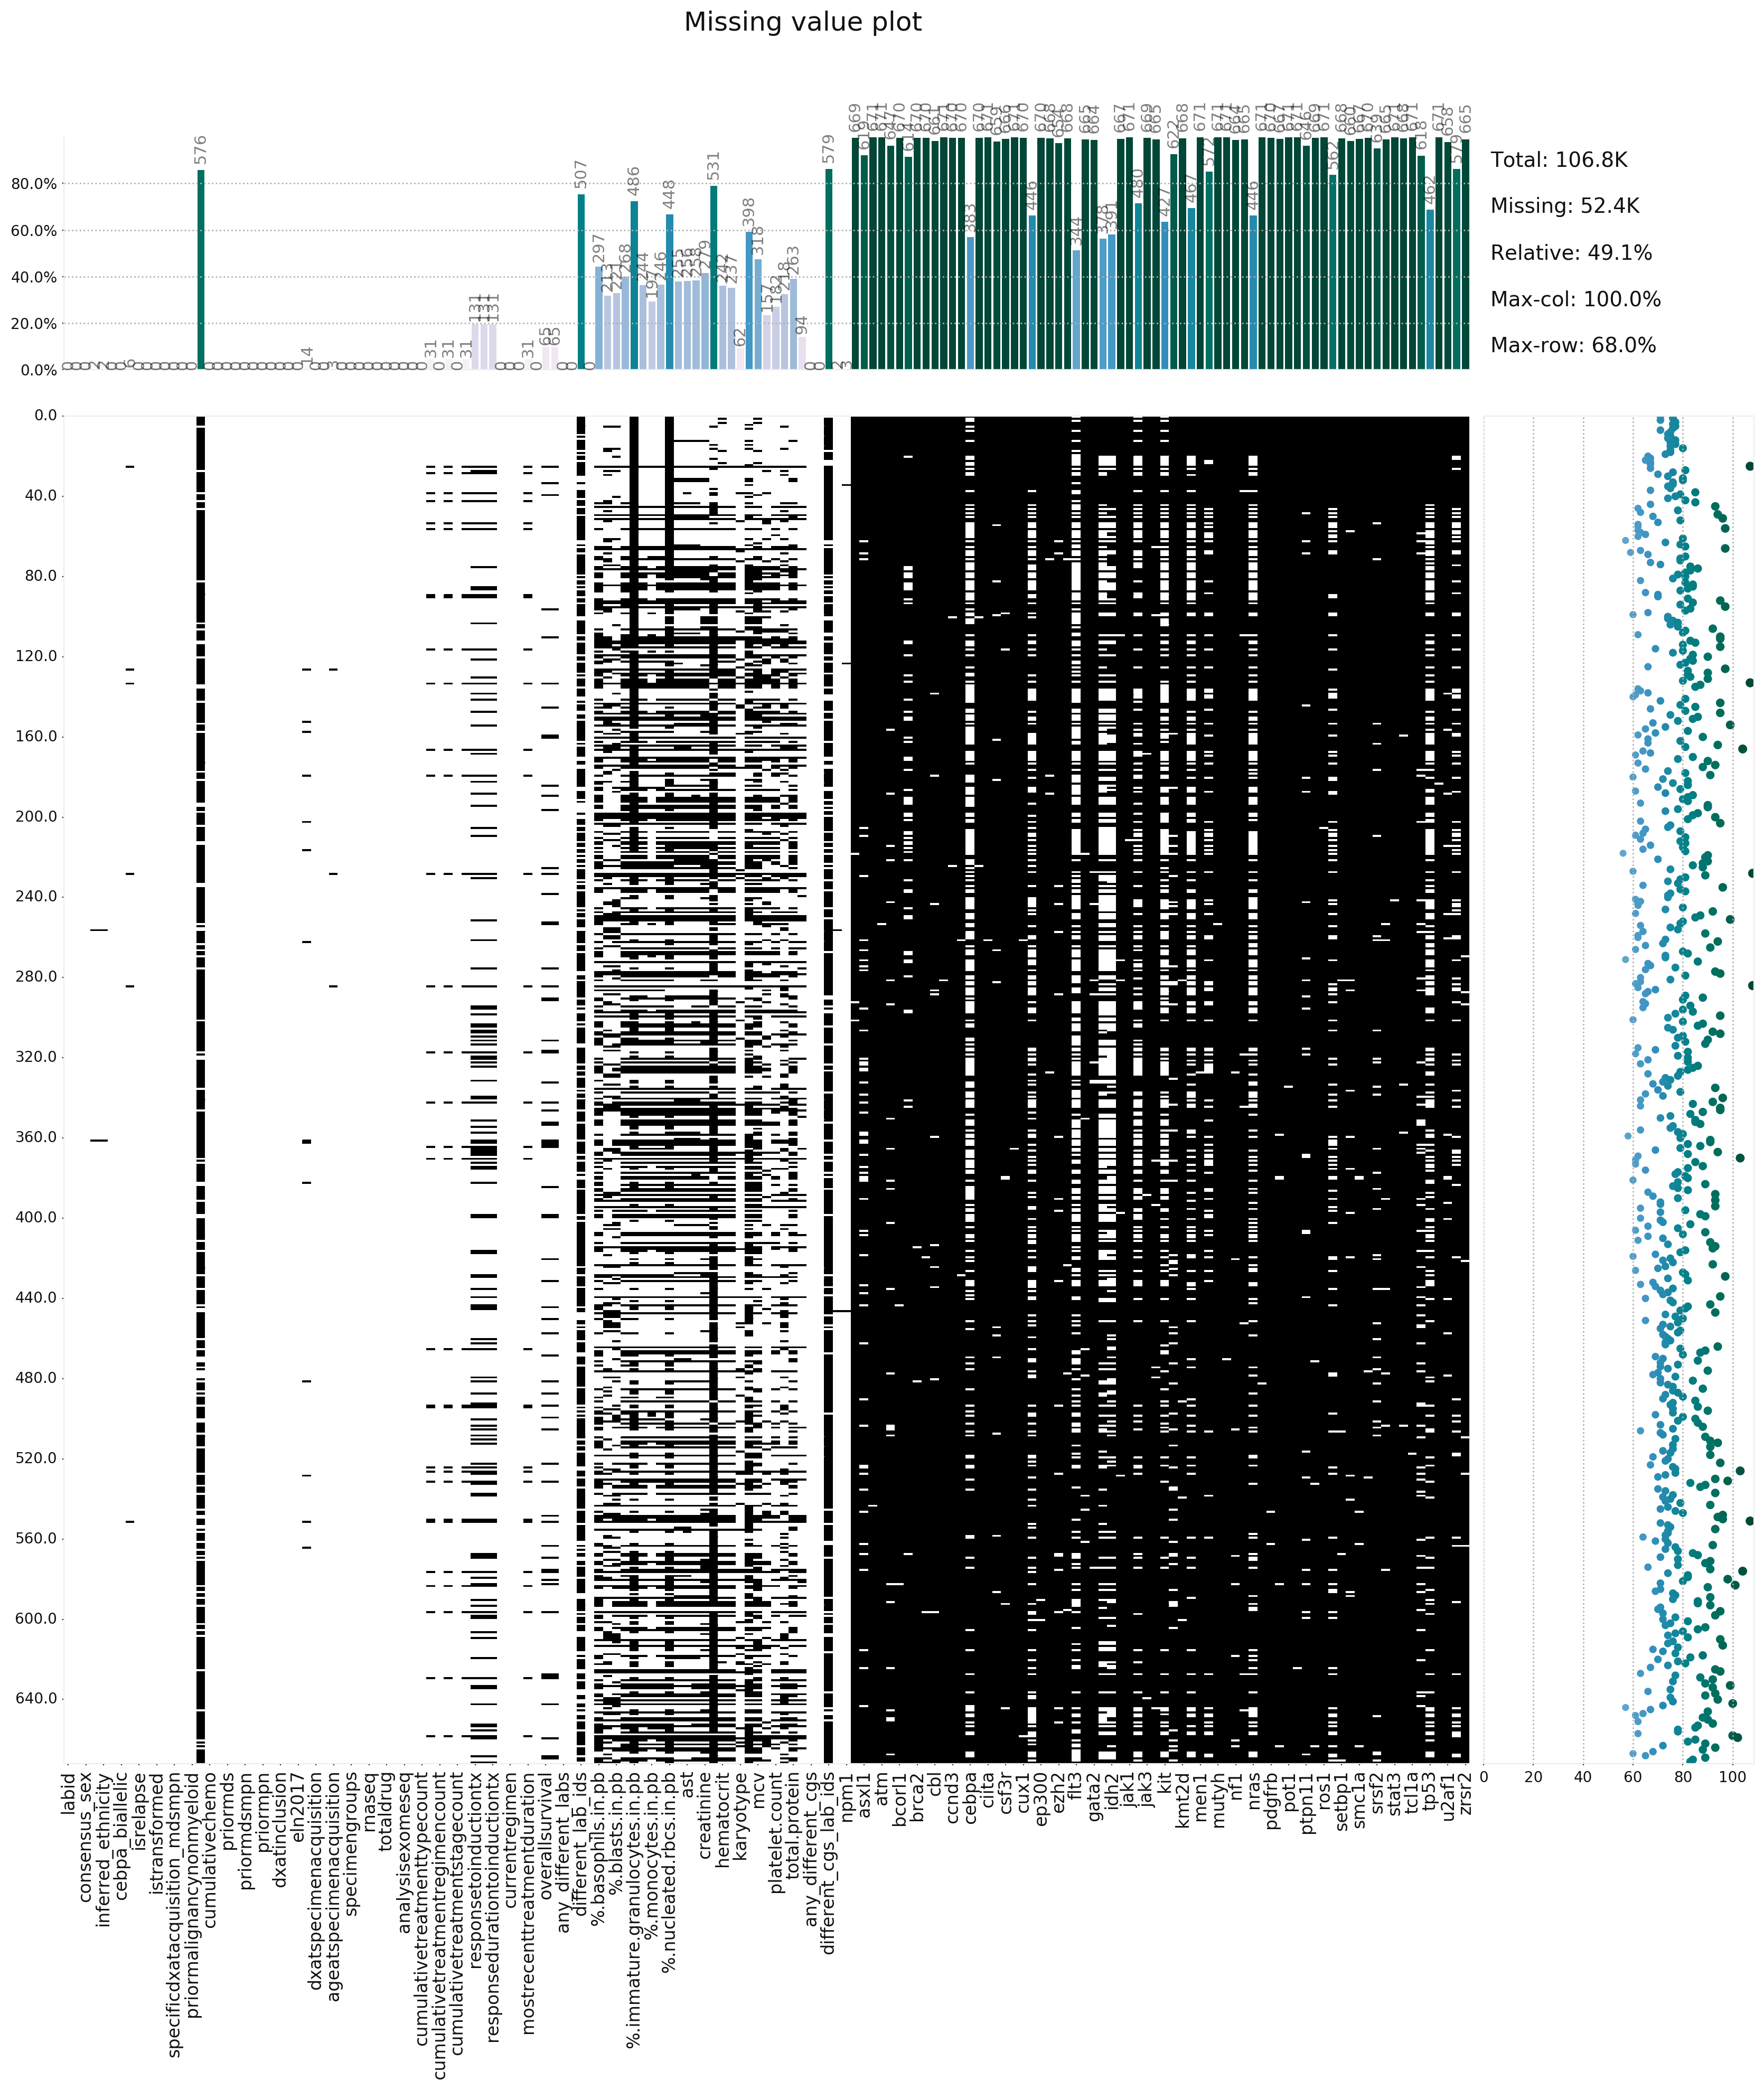

In [133]:
klib.missingval_plot(clsm)

### Select Relevant Features

In [134]:
clsm_cut = pd.DataFrame(clsm[['labid', 'patientid', 'consensus_sex', 'inferred_ethnicity', 'isrelapse',
                             'istransformed', 'priormalignancynonmyeloid', 'priormds', 'priormdsmpn', 'priormpn',
                             'eln2017', 'dxatspecimenacquisition', 'vitalstatus', 'overallsurvival', '%.blasts.in.bm', 
                              '%.blasts.in.pb','flt3-itd', 'npm1']])

clsm_cut

labid  patientid consensus_sex inferred_ethnicity  isrelapse  \
0    09-00705        163          Male              White      False   
1    10-00136        174          Male              White      False   
2    10-00172        175        Female              White      False   
3    10-00507         45        Female              White      False   
4    10-00542        174          Male              White       True   
..        ...        ...           ...                ...        ...   
667  17-00072       4366          Male              White      False   
668  17-00077       4317        Female              White      False   
669  17-00093       4379        Female              Black      False   
670  17-00094       4380          Male              White      False   
671  17-00096       2747          Male              White      False   

     istransformed priormalignancynonmyeloid priormds priormdsmpn priormpn  \
0            False                         n        n           n        n   
1            False                         n        n           n        n   
2            False                         n        n           n        n   
3            False                         n        n           n        n   
4            False                         n        n           n        n   
..             ...                       ...      ...         ...      ...   
667           True                         n        n           n        y   
668          False                         n        n           n        n   
669           True                         n        n           n        y   
670           True                         n        n           n        y   
671           True                         n        n           y        n   

                     eln2017  \
0    FavorableOrIntermediate   
1                    Adverse   
2      IntermediateOrAdverse   
3    FavorableOrIntermediate   
4                    Adverse   
..                       ...   
667             Intermediate   
668                Favorable   
669             Intermediate   
670                  Adverse   
671             Intermediate   

                               dxatspecimenacquisition vitalstatus  \
0    ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
1    ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
2    ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
3    ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
4    ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
..                                                 ...         ...   
667  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
668  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...     Unknown   
669  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...     Unknown   
670  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...       Alive   
671  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...       Alive   

     overallsurvival %.blasts.in.bm %.blasts.in.pb  flt3-itd      npm1  
0              425.0             94             97  positive  positive  
1              419.0             80             19  positive  negative  
2              541.0             91             99  positive  negative  
3              511.0             97             97  positive  positive  
4              419.0             87             80  positive  negative  
..               ...            ...            ...       ...       ...  
667            362.0            NaN           53.2  negative  negative  
668              NaN             90             74  negative  negative  
669              NaN            NaN             48  positive  negative  
670            153.0             20            NaN  negative  negative  
671            256.0            NaN            NaN  negative  negative  

[672 rows x 18 columns]

In [135]:
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         670 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            607 non-null    float64

In [136]:
clsm_cut.describe()

patientid  overallsurvival
count   672.000000       607.000000
mean   2088.020833       441.881384
std     973.372734       479.180429
min      17.000000        -1.000000
25%    1450.750000       167.000000
50%    2016.000000       323.000000
75%    2501.500000       555.000000
max    4380.000000      5305.000000

### Attibute Tranformation

%.blasts.in.bm Attribute:

In [137]:
clsm_cut['%.blasts.in.bm'].unique()

array(['94', '80', '91', '97', '87', nan, '40', '75', '83', '95', '85',
       '90', '70', '92', '72', '68', '88', '36', '81', '93', '34', '77.5',
       '46', '65', '50', '76', '71', '60', '73', '55', '0.5', '30', '62',
       '18', '82', '28', '41', '64', '84', '21', '51', '17', '49.4', '32',
       '29', '25', '59.3', '66', '20', '52', '54', '22', '10', '12',
       '46.0', '13', '67', '39', '25.9', '45', '37', '78', '8', '3',
       '54.8', '74', '96', '4', '86.1', '42', '56', '69', '79', '33', '9',
       '.4', '51.5', '15', '5', '24', '7', '2', '6', '1', '58', '>50',
       '35', '86', '32.0', '93.2', '0', '27', '89.6', '23', '98', '19',
       '91.8', '>95', '57', '71.5', '78.3', '63', '1.5', '53.74', '59.5',
       '44', '42.5', '26', '3.5', '48', '26.3', '47', '88.5'],
      dtype=object)

In [138]:
# > and < will be changed to whole numbers less than or greater than.
clsm_cut['%.blasts.in.bm'] = clsm_cut['%.blasts.in.bm'].replace(['>50'], 51)
clsm_cut['%.blasts.in.bm'] = clsm_cut['%.blasts.in.bm'].replace(['>95'], 96)

clsm_cut['%.blasts.in.bm'].unique()

array(['94', '80', '91', '97', '87', nan, '40', '75', '83', '95', '85',
       '90', '70', '92', '72', '68', '88', '36', '81', '93', '34', '77.5',
       '46', '65', '50', '76', '71', '60', '73', '55', '0.5', '30', '62',
       '18', '82', '28', '41', '64', '84', '21', '51', '17', '49.4', '32',
       '29', '25', '59.3', '66', '20', '52', '54', '22', '10', '12',
       '46.0', '13', '67', '39', '25.9', '45', '37', '78', '8', '3',
       '54.8', '74', '96', '4', '86.1', '42', '56', '69', '79', '33', '9',
       '.4', '51.5', '15', '5', '24', '7', '2', '6', '1', '58', 51, '35',
       '86', '32.0', '93.2', '0', '27', '89.6', '23', '98', '19', '91.8',
       96, '57', '71.5', '78.3', '63', '1.5', '53.74', '59.5', '44',
       '42.5', '26', '3.5', '48', '26.3', '47', '88.5'], dtype=object)

%.blasts.in.pb Attribute:

In [139]:
clsm_cut['%.blasts.in.pb'].unique()

array(['97', '19', '99', '80', nan, '51', '30', '41', '84', '77', '75',
       '63', '60', '96', '66', '45', '93', '9', '82', '15', '33', '0',
       '13', '94', '89', '83', '>90', '78', '72', '59', '32', '6', '29',
       '24', '64', '57', '52', '2.1', '<5', '17', '22', '5', '47', '56',
       '25', '23', '42', '65', '71', '8', '3.5', '66.3', '95', '44', '10',
       '28.6', '18', '58', '67', '40', '92', '54', '1.0', '2', '20', '28',
       '35', '85', '1', '42.4', '16', '49.1', '14', '88', '46', '7',
       '0.5', '79', '26', '87', '20.4', '68', '48', '5.3', '61', '90',
       '17.4', '57.4', '43.8', '50', '37', '4', '3', '12', '81', '11',
       '90.5', '"""rare"""', '90.2', '55', '12.0', 'rare', '39', '31.0',
       '86', '47.4', '27.4', '39.6', '83.0', '12.9', '5.0', '15.4', '9.5',
       '62', '64.6', '27.8', '69.14', '52.2', '91', '67.25', '49', '23.7',
       '48.6', '98', '74.8', '2.6', '43', '29.6', '47.5', '38', '2.5',
       '25.2', '3.56', '70', '99.2', '73', '26.7', '38.5

In [140]:
#%.Blasts.in.PB attribute has 1 "rare" record with no flt3 nor npm1 input. This will be changed to NAN
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].replace(['"""rare"""'], np.nan)
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].replace(['rare'], np.nan)
# > and < will be changed to whole numbers less than or greater than. 
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].replace(['<5'], 4)
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].replace(['>90'], 91)

clsm_cut['%.blasts.in.pb'].unique()

array(['97', '19', '99', '80', nan, '51', '30', '41', '84', '77', '75',
       '63', '60', '96', '66', '45', '93', '9', '82', '15', '33', '0',
       '13', '94', '89', '83', 91, '78', '72', '59', '32', '6', '29',
       '24', '64', '57', '52', '2.1', 4, '17', '22', '5', '47', '56',
       '25', '23', '42', '65', '71', '8', '3.5', '66.3', '95', '44', '10',
       '28.6', '18', '58', '67', '40', '92', '54', '1.0', '2', '20', '28',
       '35', '85', '1', '42.4', '16', '49.1', '14', '88', '46', '7',
       '0.5', '79', '26', '87', '20.4', '68', '48', '5.3', '61', '90',
       '17.4', '57.4', '43.8', '50', '37', '4', '3', '12', '81', '11',
       '90.5', '90.2', '55', '12.0', '39', '31.0', '86', '47.4', '27.4',
       '39.6', '83.0', '12.9', '5.0', '15.4', '9.5', '62', '64.6', '27.8',
       '69.14', '52.2', '91', '67.25', '49', '23.7', '48.6', '98', '74.8',
       '2.6', '43', '29.6', '47.5', '38', '2.5', '25.2', '3.56', '70',
       '99.2', '73', '26.7', '38.5', '7.7', '74', '93.3', '12.

#### From Categorical to Numerical
Transform %.blasts.in.bm and %.blasts.in.pb from object to float:

In [141]:
clsm_cut['%.blasts.in.bm'] = clsm_cut['%.blasts.in.bm'].astype(float)
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].astype(float)


clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         670 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            607 non-null    float64

### clsm_cut Identify Missing Values

GridSpec(6, 6)

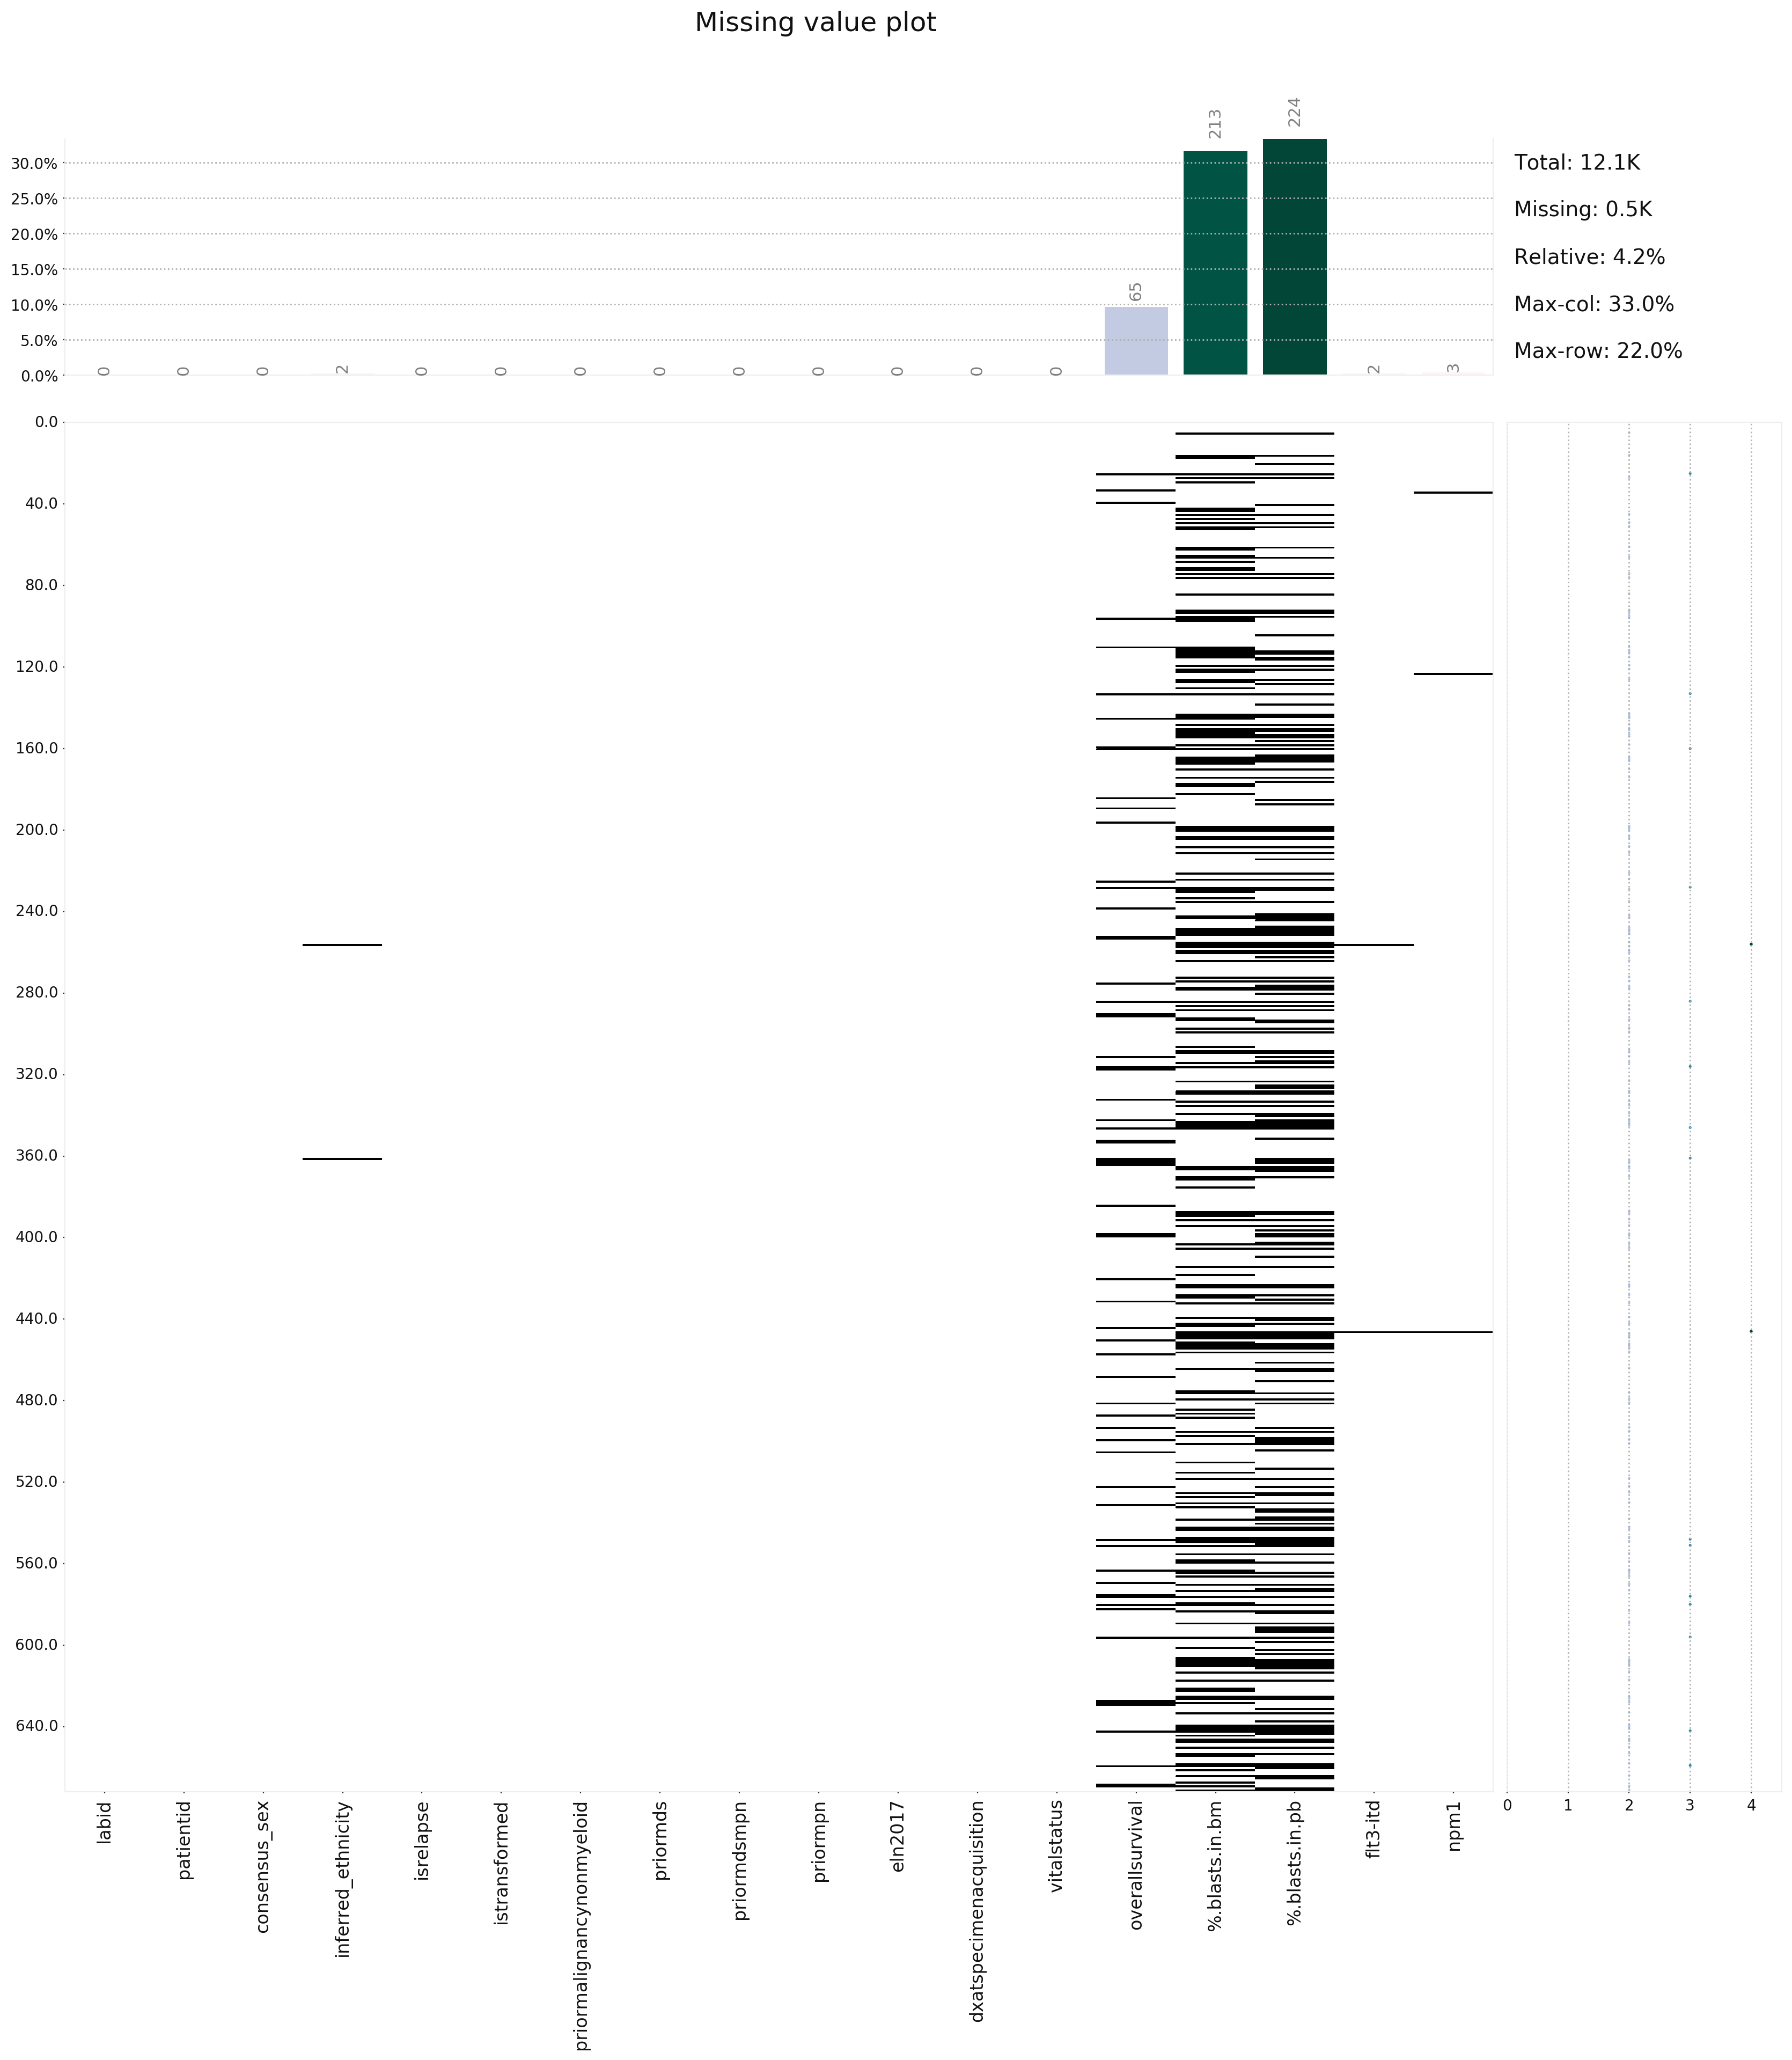

In [142]:
klib.missingval_plot(clsm_cut)

### Replace Missing Values

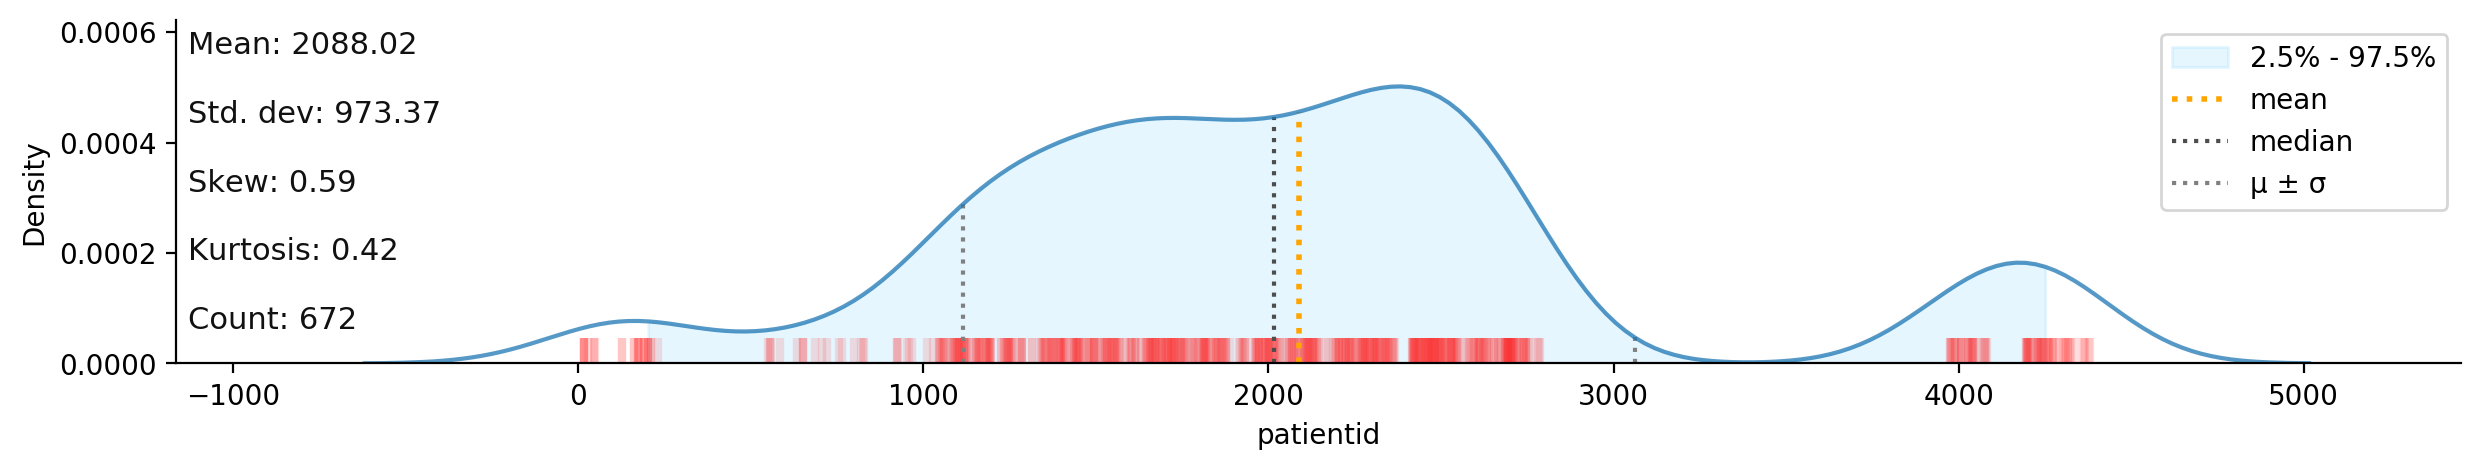

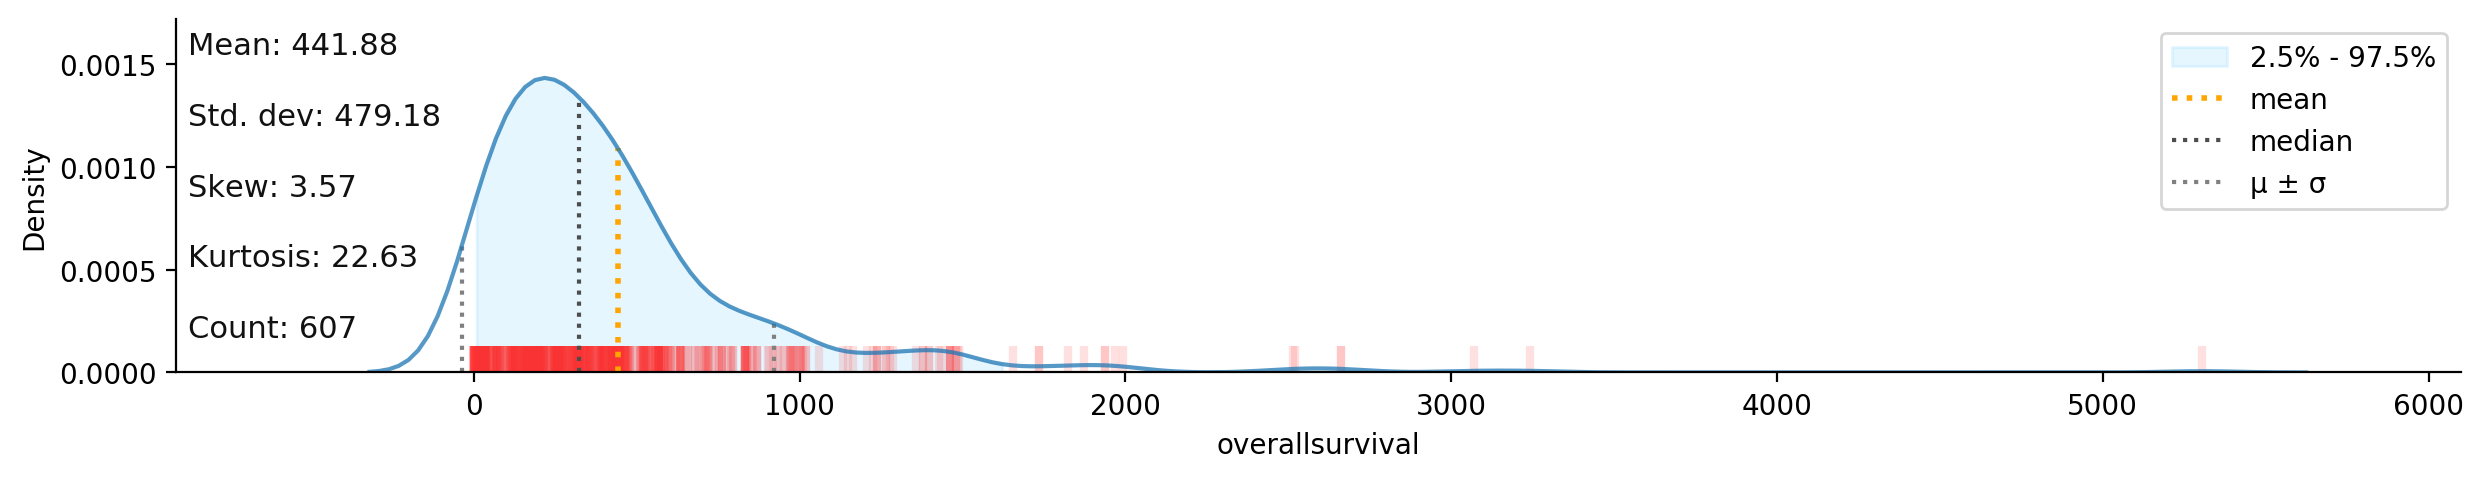

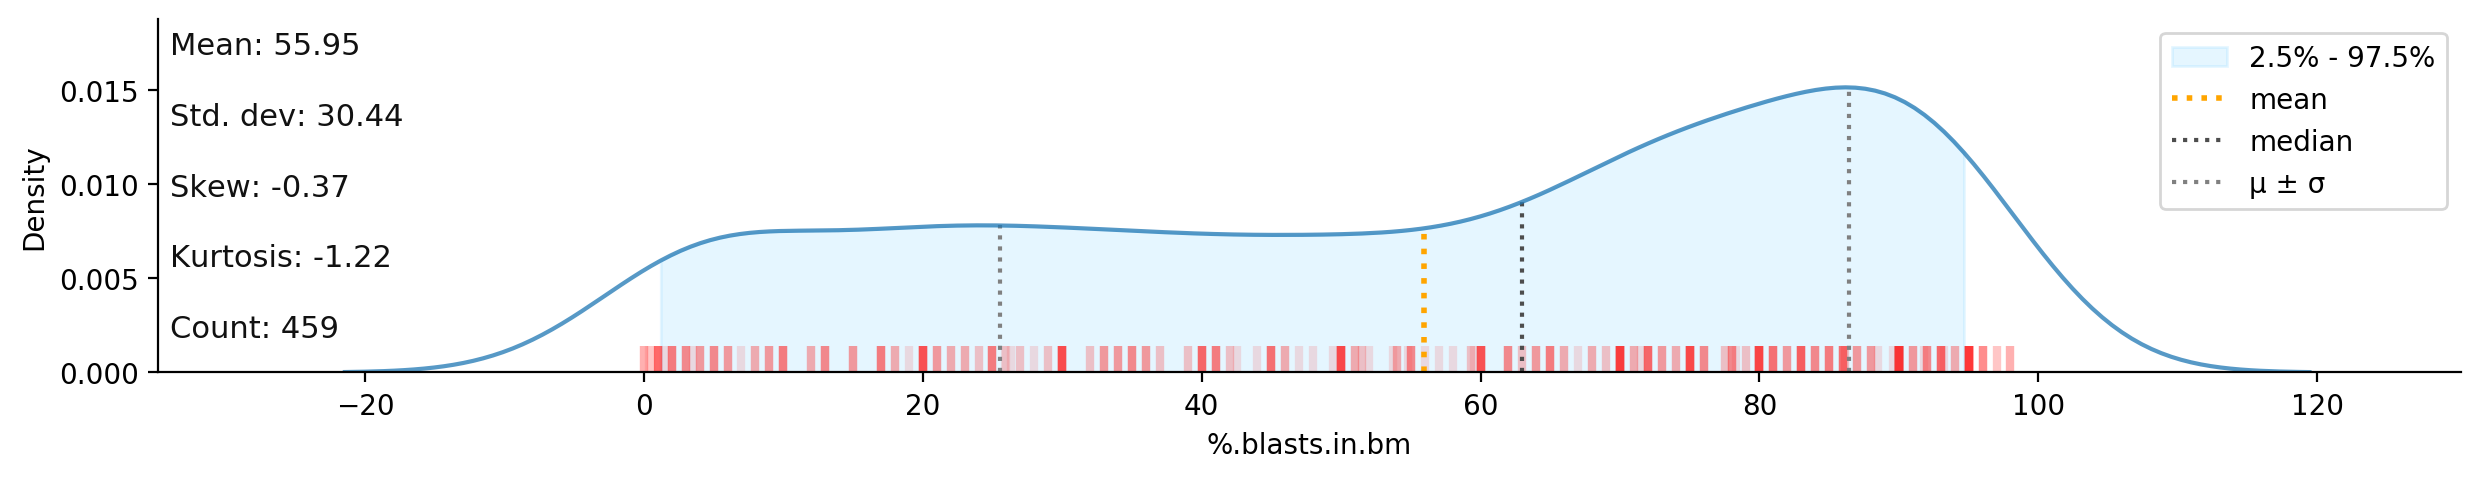

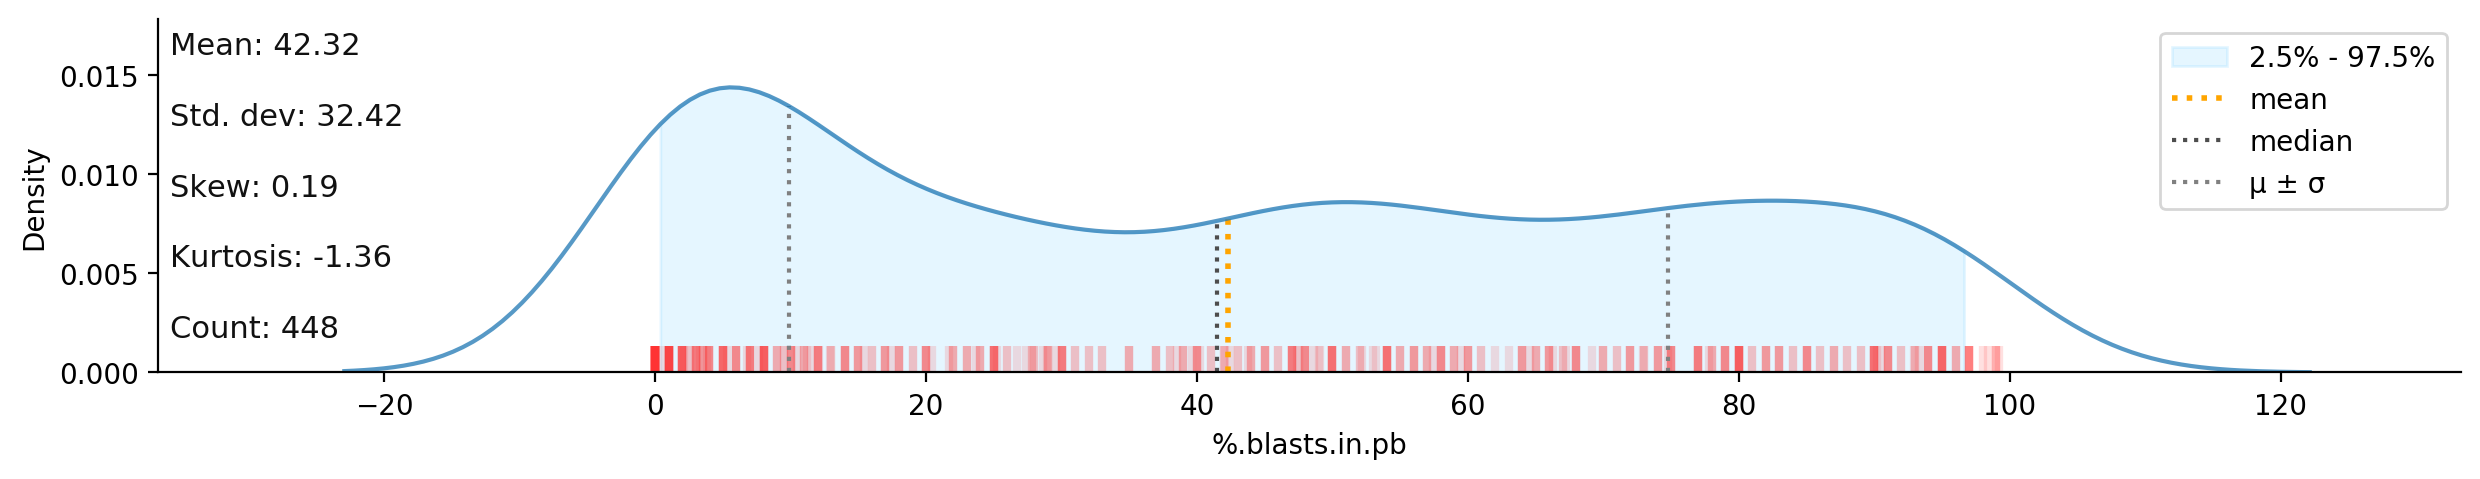

In [143]:
klib.dist_plot(clsm_cut)

In [144]:
clsm_cut.describe()

patientid  overallsurvival  %.blasts.in.bm  %.blasts.in.pb
count   672.000000       607.000000      459.000000      448.000000
mean   2088.020833       441.881384       55.949325       42.316629
std     973.372734       479.180429       30.440925       32.418249
min      17.000000        -1.000000        0.000000        0.000000
25%    1450.750000       167.000000       30.000000       10.000000
50%    2016.000000       323.000000       63.000000       41.500000
75%    2501.500000       555.000000       83.000000       72.000000
max    4380.000000      5305.000000       98.000000       99.200000

In [145]:
#From distibution, skewness suggest median is the best representation. 
clsm_cut['overallsurvival'] = clsm_cut['overallsurvival'].fillna(clsm_cut['overallsurvival'].median())
clsm_cut['%.blasts.in.bm'] = clsm_cut['%.blasts.in.bm'].fillna(clsm_cut['%.blasts.in.bm'].median())
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].fillna(clsm_cut['%.blasts.in.pb'].median())

In [146]:
#Replace categorical NaN with unknown 
clsm_cut = clsm_cut.replace(np.nan, 'unknown', regex=True)

In [147]:
#Determine mode of inferred_ethnicity:
clsm_cut['inferred_ethnicity'].mode()

0    White
dtype: object

In [148]:
#In inferred_ethnicity, replace mode of unknown to white:
clsm_cut['inferred_ethnicity'] = clsm_cut['inferred_ethnicity'].replace(['unknown'], 'white')

clsm_cut['inferred_ethnicity'].unique()

array(['White', 'HispNative', 'AdmixedBlack', 'Asian', 'Black',
       'AdmixedAsian', 'white', 'AdmixedWhite', 'AdmixedHispNative'],
      dtype=object)

In [149]:
#Determine mode of flt3-itd:
clsm_cut['flt3-itd'].mode()

0    negative
dtype: object

In [150]:
#In flt3-itd, replace mode of unknown to negative:
clsm_cut['flt3-itd'] = clsm_cut['flt3-itd'].replace(['unknown'], 'negative')

clsm_cut['flt3-itd'].unique()

array(['positive', 'negative'], dtype=object)

In [151]:
#Determine mode of npm1:
clsm_cut['npm1'].mode()

0    negative
dtype: object

In [152]:
#In npm1, replace mode of unknown to negative:
clsm_cut['npm1'] = clsm_cut['npm1'].replace(['unknown'], 'negative')

clsm_cut['npm1'].unique()

array(['positive', 'negative'], dtype=object)

In [153]:
klib.missingval_plot(clsm_cut)

No missing values found in the dataset.


In [154]:
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         672 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            672 non-null    float64

### Check for Duplicates

In [155]:
clsm_cut = clsm_cut.drop_duplicates(ignore_index=True)
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         672 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            672 non-null    float64

### Visualization

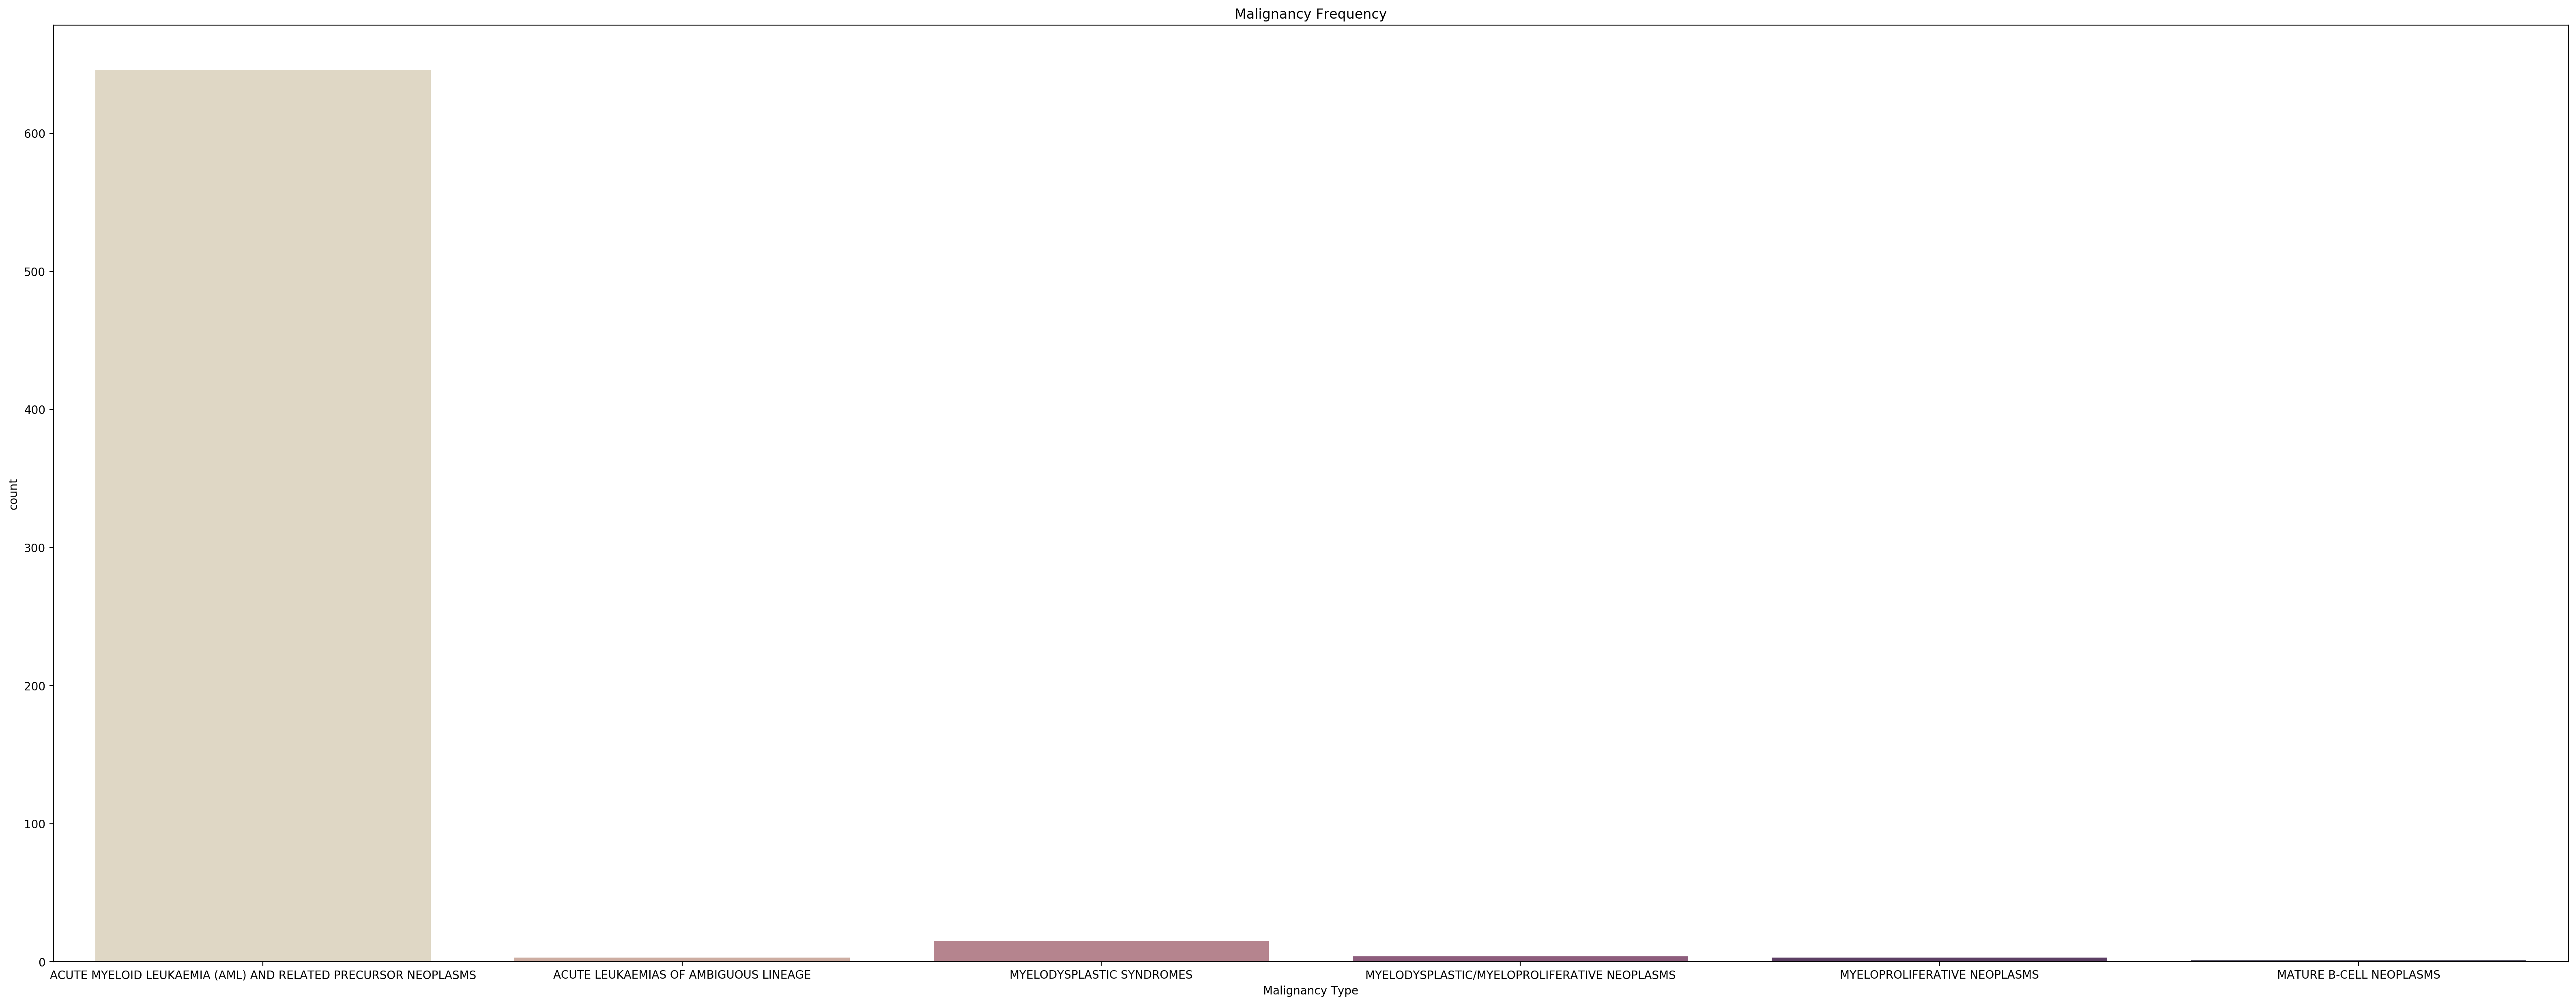

In [156]:
sns.countplot(x=clsm_cut["dxatspecimenacquisition"], palette = "ch:s=-.2,r=.6")
plt.xlabel('Malignancy Type')
plt.title('Malignancy Frequency')
plt.gcf().set_size_inches(40, 15)

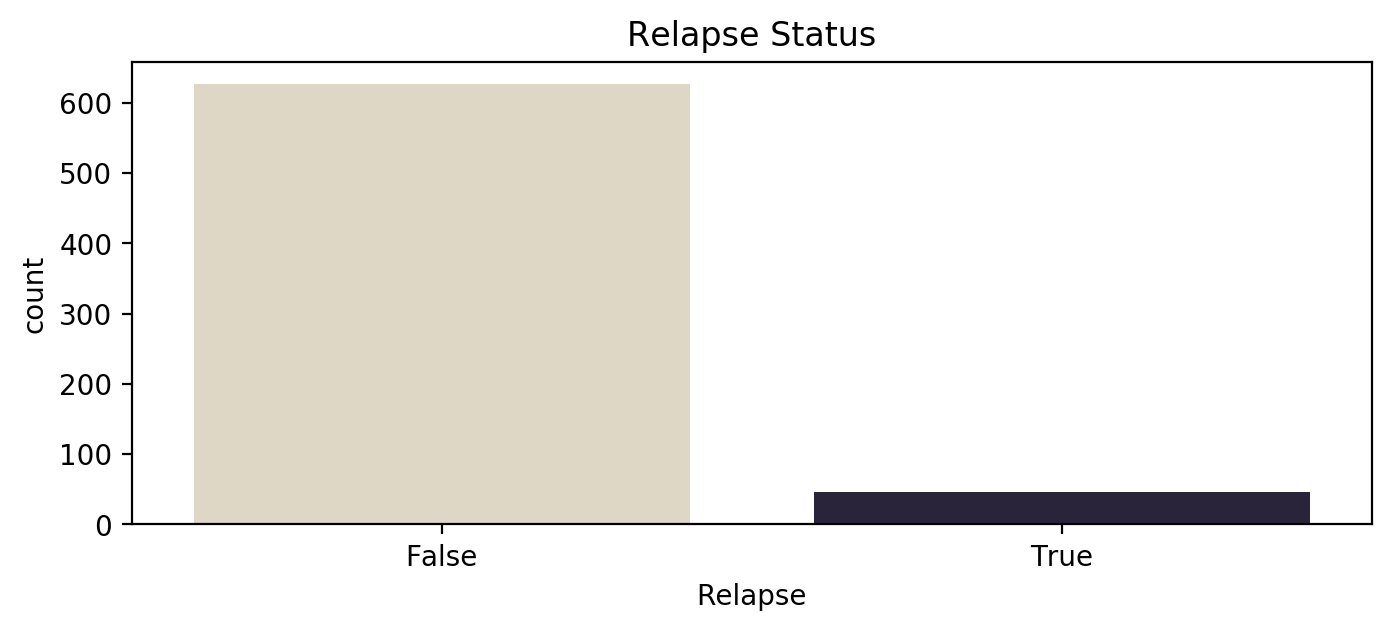

In [157]:
sns.countplot(x=clsm_cut["isrelapse"], palette = "ch:s=-.2,r=.6")
plt.xlabel('Relapse')
plt.title('Relapse Status')
plt.gcf().set_size_inches(8, 3)

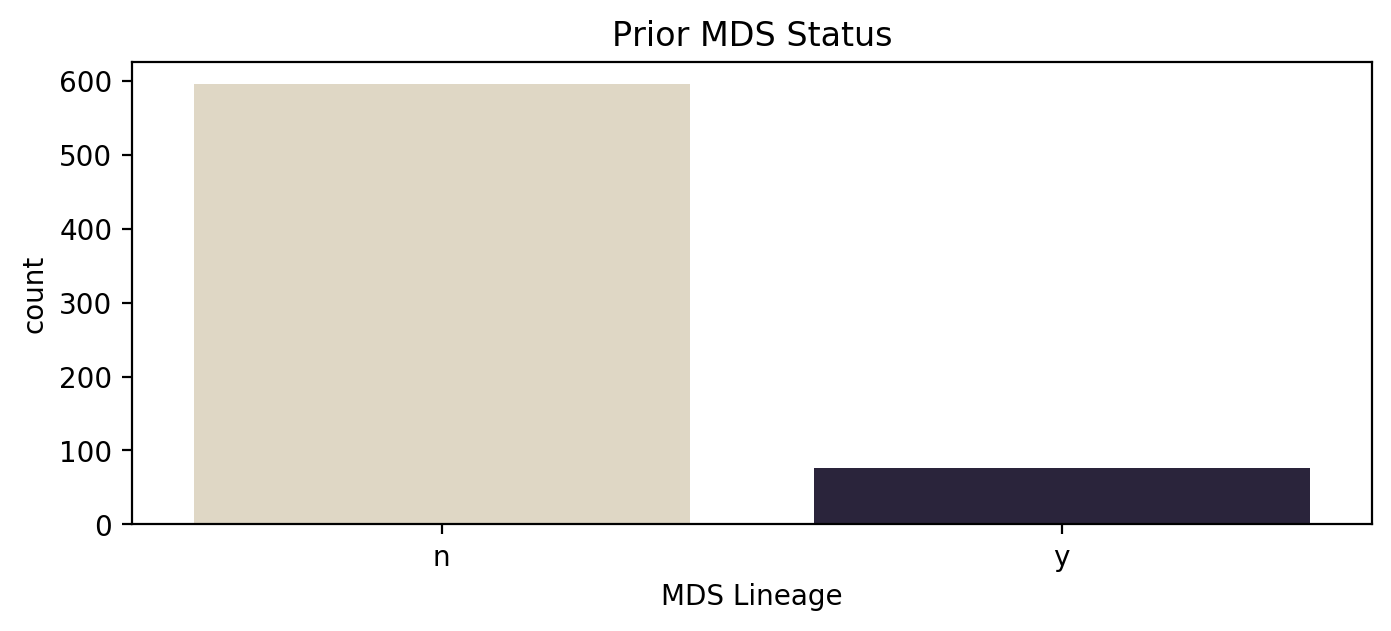

In [158]:
sns.countplot(x=clsm_cut["priormds"], palette = "ch:s=-.2,r=.6")
plt.xlabel('MDS Lineage')
plt.title('Prior MDS Status')
plt.gcf().set_size_inches(8, 3)

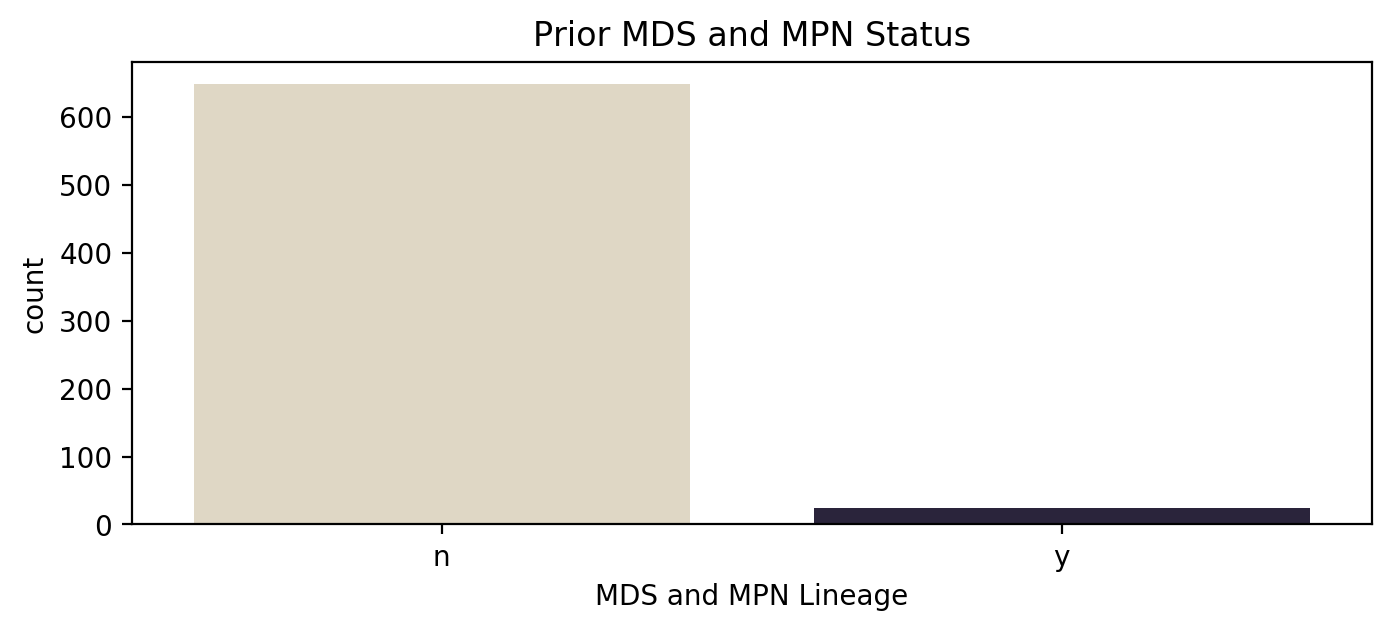

In [159]:
sns.countplot(x=clsm_cut["priormdsmpn"], palette = "ch:s=-.2,r=.6")
plt.xlabel('MDS and MPN Lineage')
plt.title('Prior MDS and MPN Status')
plt.gcf().set_size_inches(8, 3)

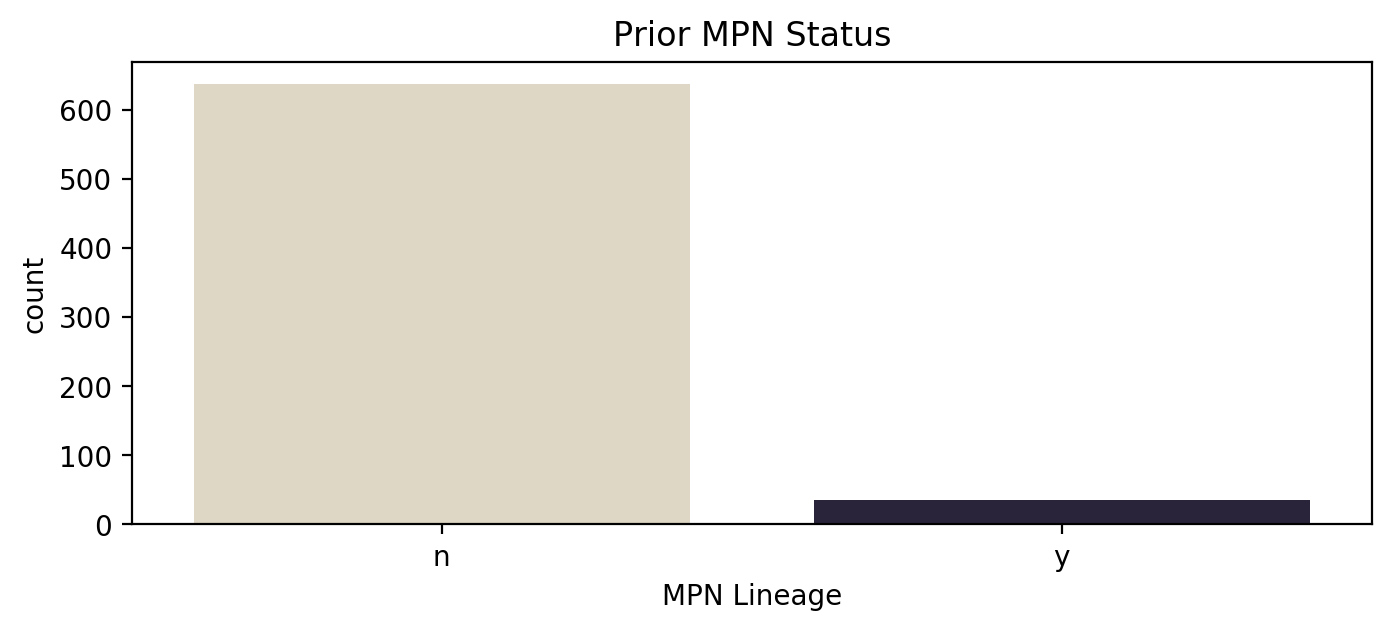

In [160]:
sns.countplot(x=clsm_cut["priormpn"], palette = "ch:s=-.2,r=.6")
plt.xlabel('MPN Lineage')
plt.title('Prior MPN Status')
plt.gcf().set_size_inches(8, 3)

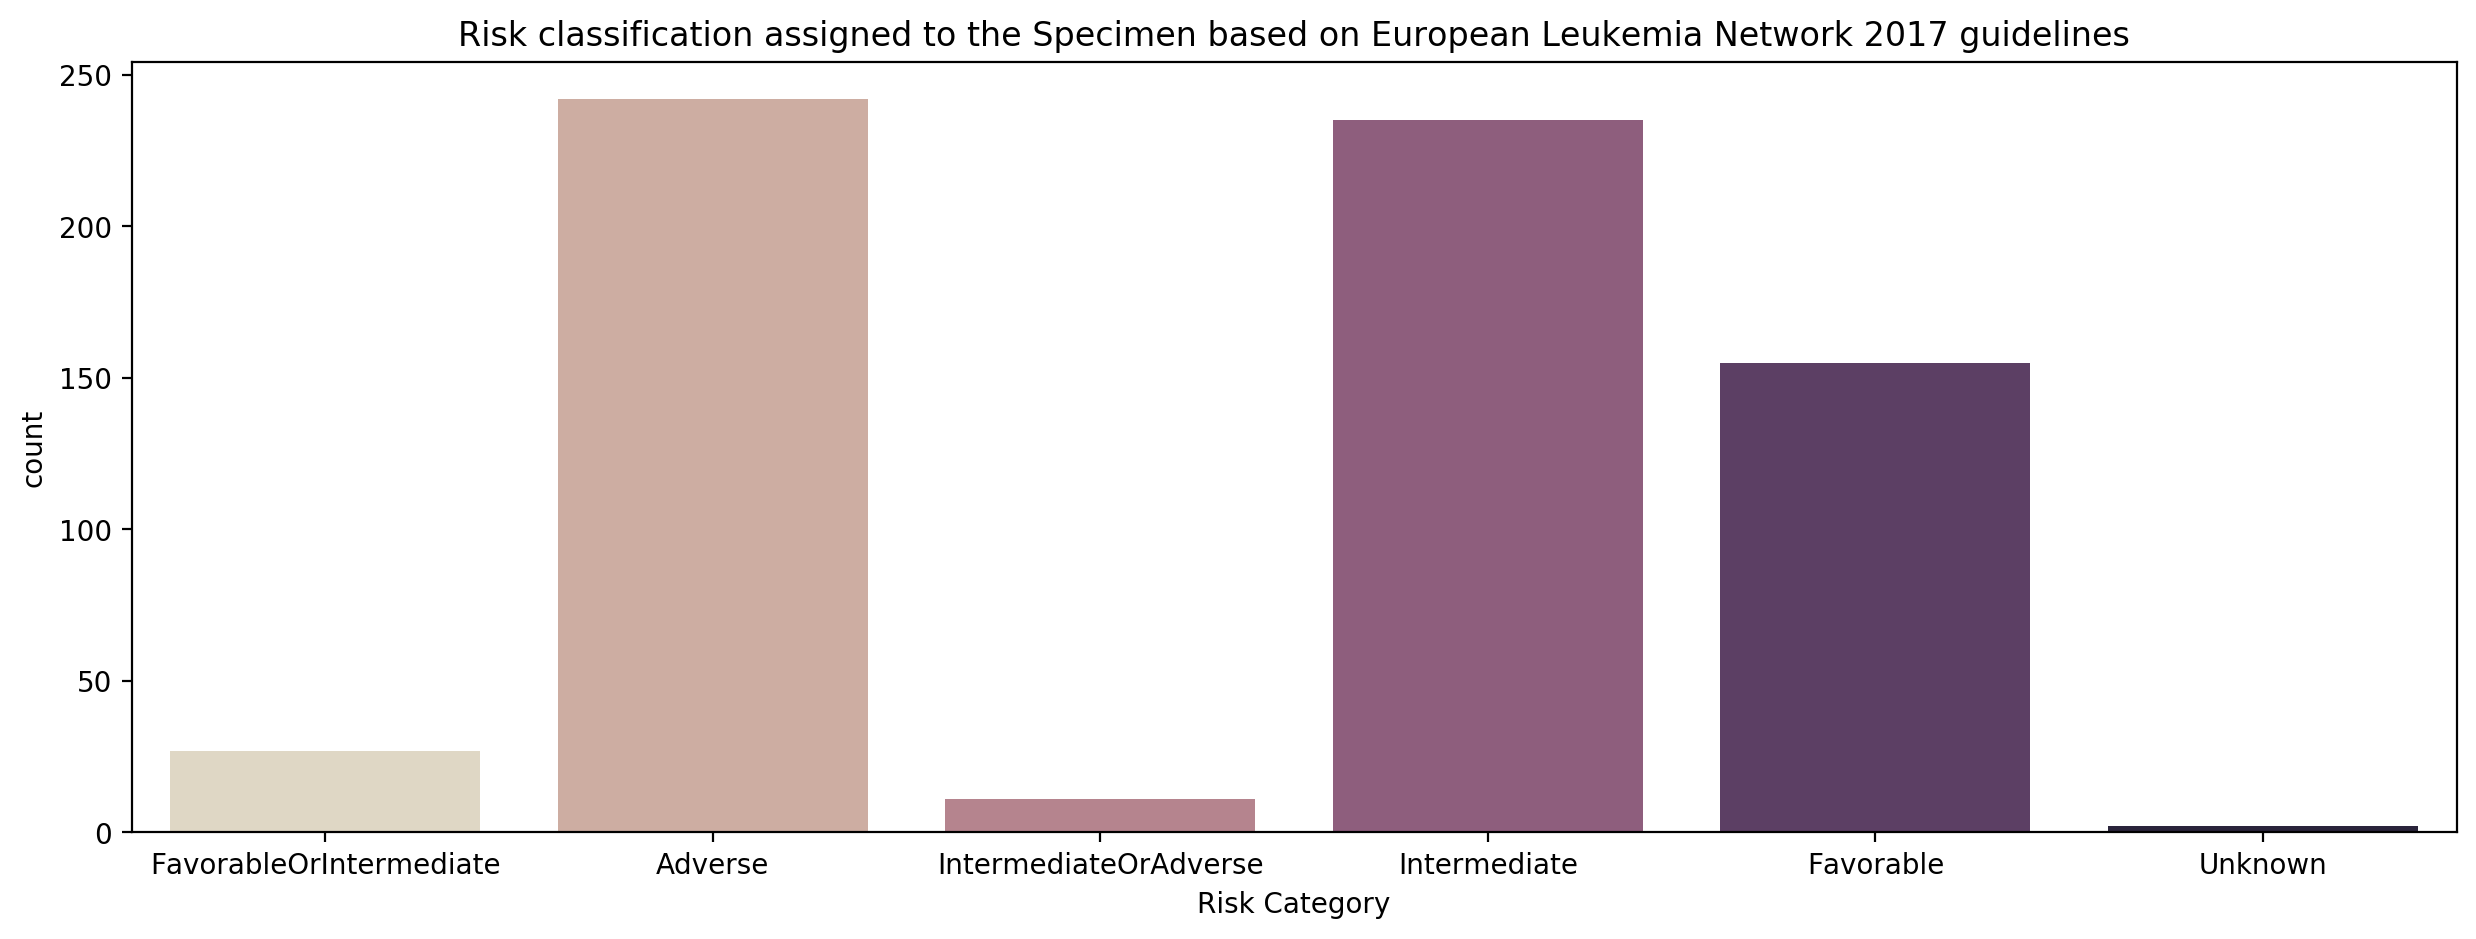

In [161]:
sns.countplot(x=clsm_cut["eln2017"], palette = "ch:s=-.2,r=.6")
plt.xlabel('Risk Category')
plt.title('Risk classification assigned to the Specimen based on European Leukemia Network 2017 guidelines')
plt.gcf().set_size_inches(15, 5)

Text(0.5, 1.0, 'Survival Against NPM1 Mutation')

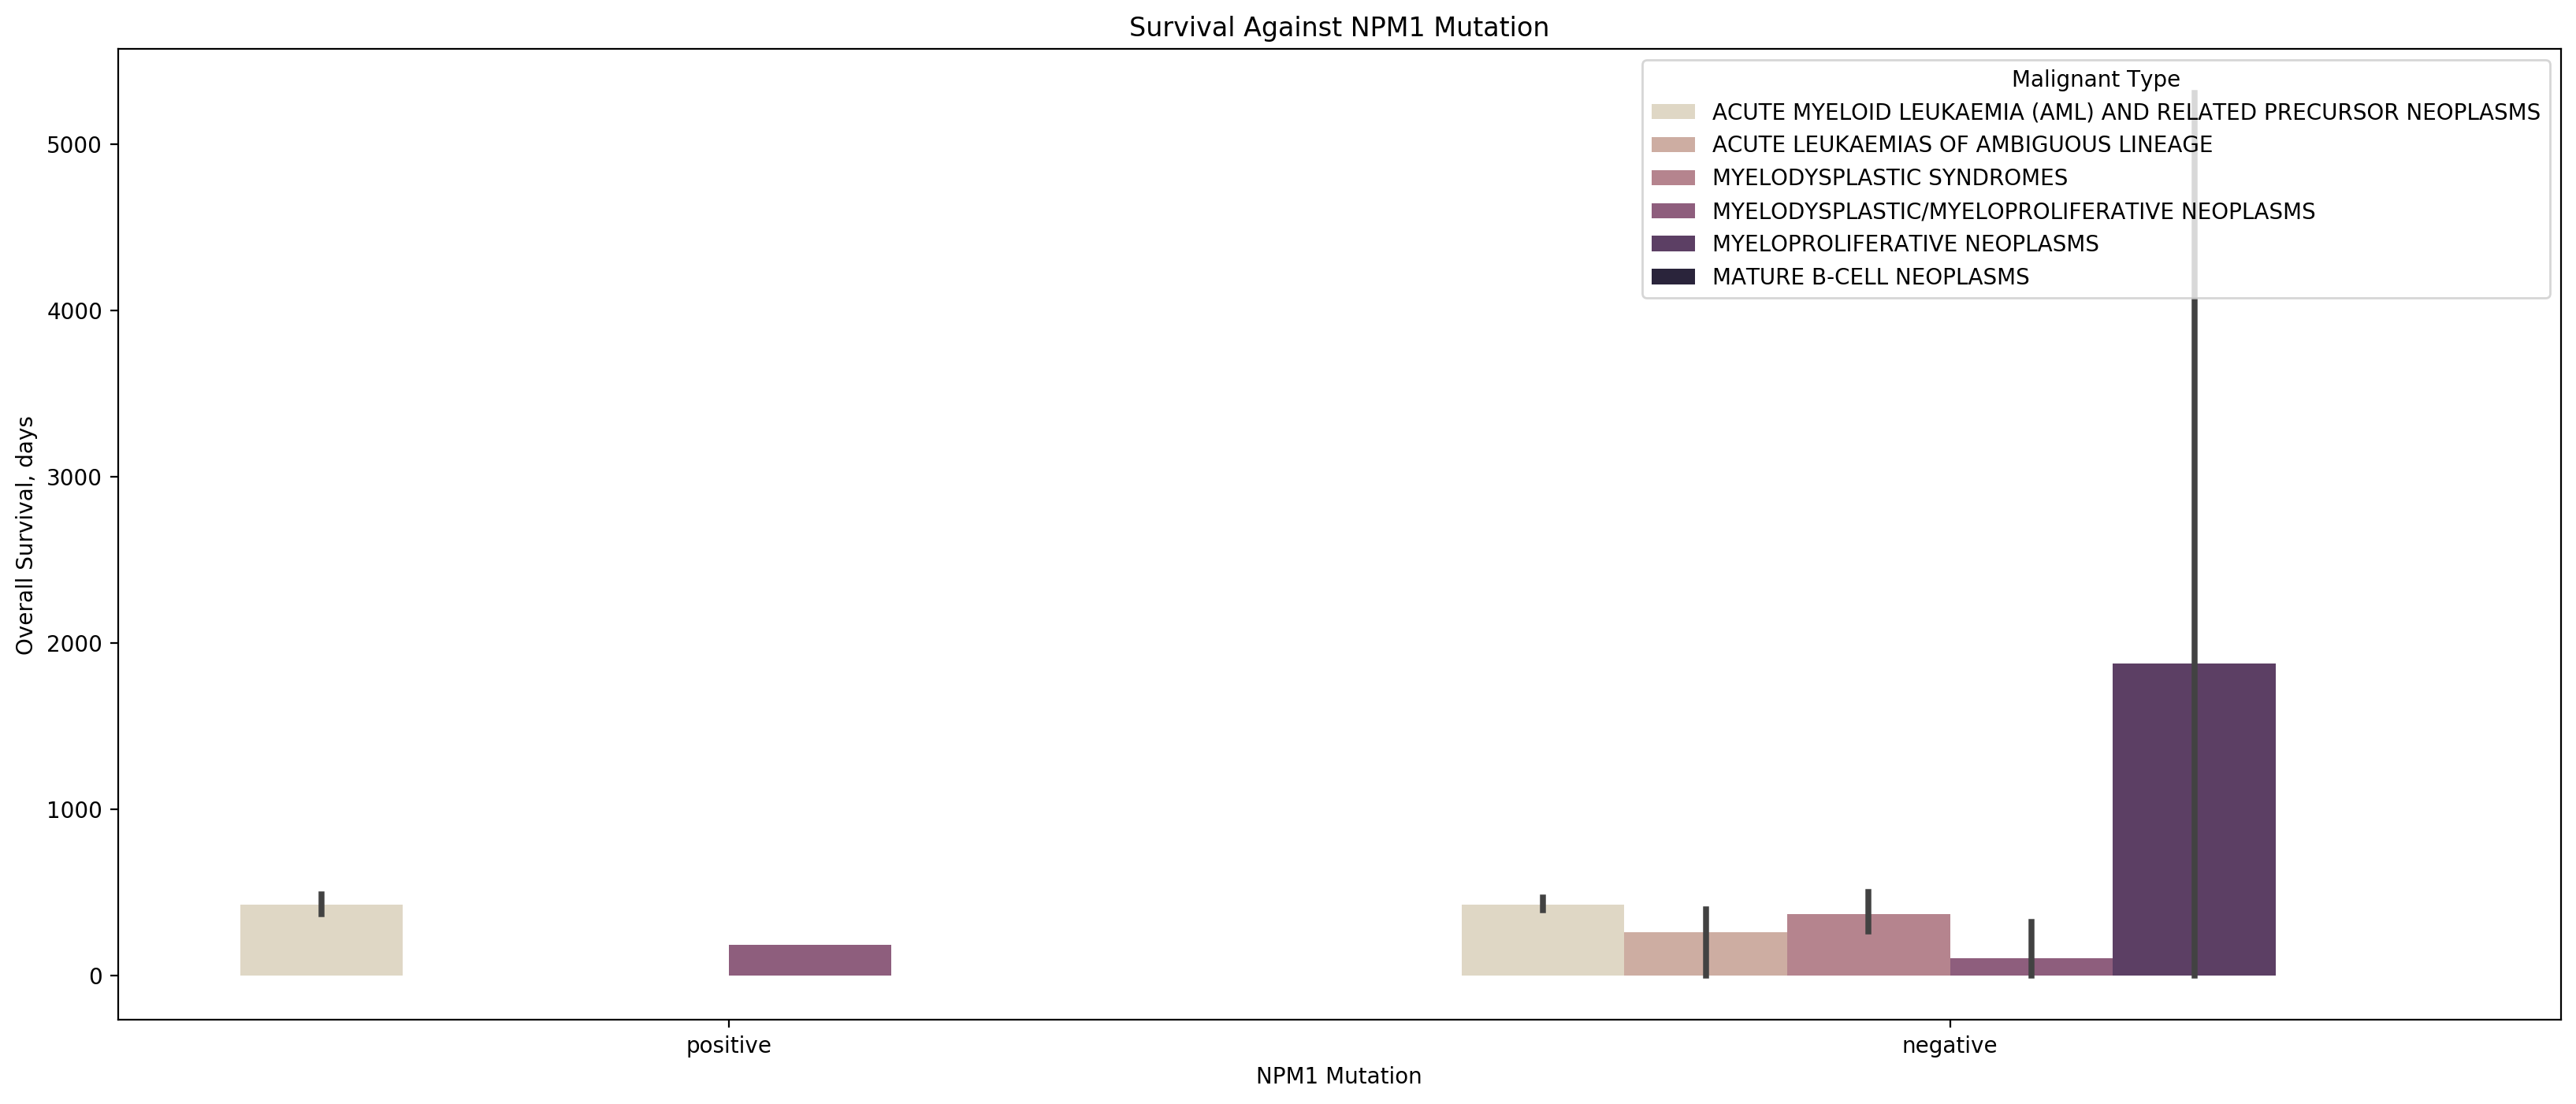

In [162]:
sns.barplot(data= clsm_cut,x = 'npm1', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('NPM1 Mutation')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against NPM1 Mutation")

Text(0.5, 1.0, 'Survival Against FLT3-ITD Mutation')

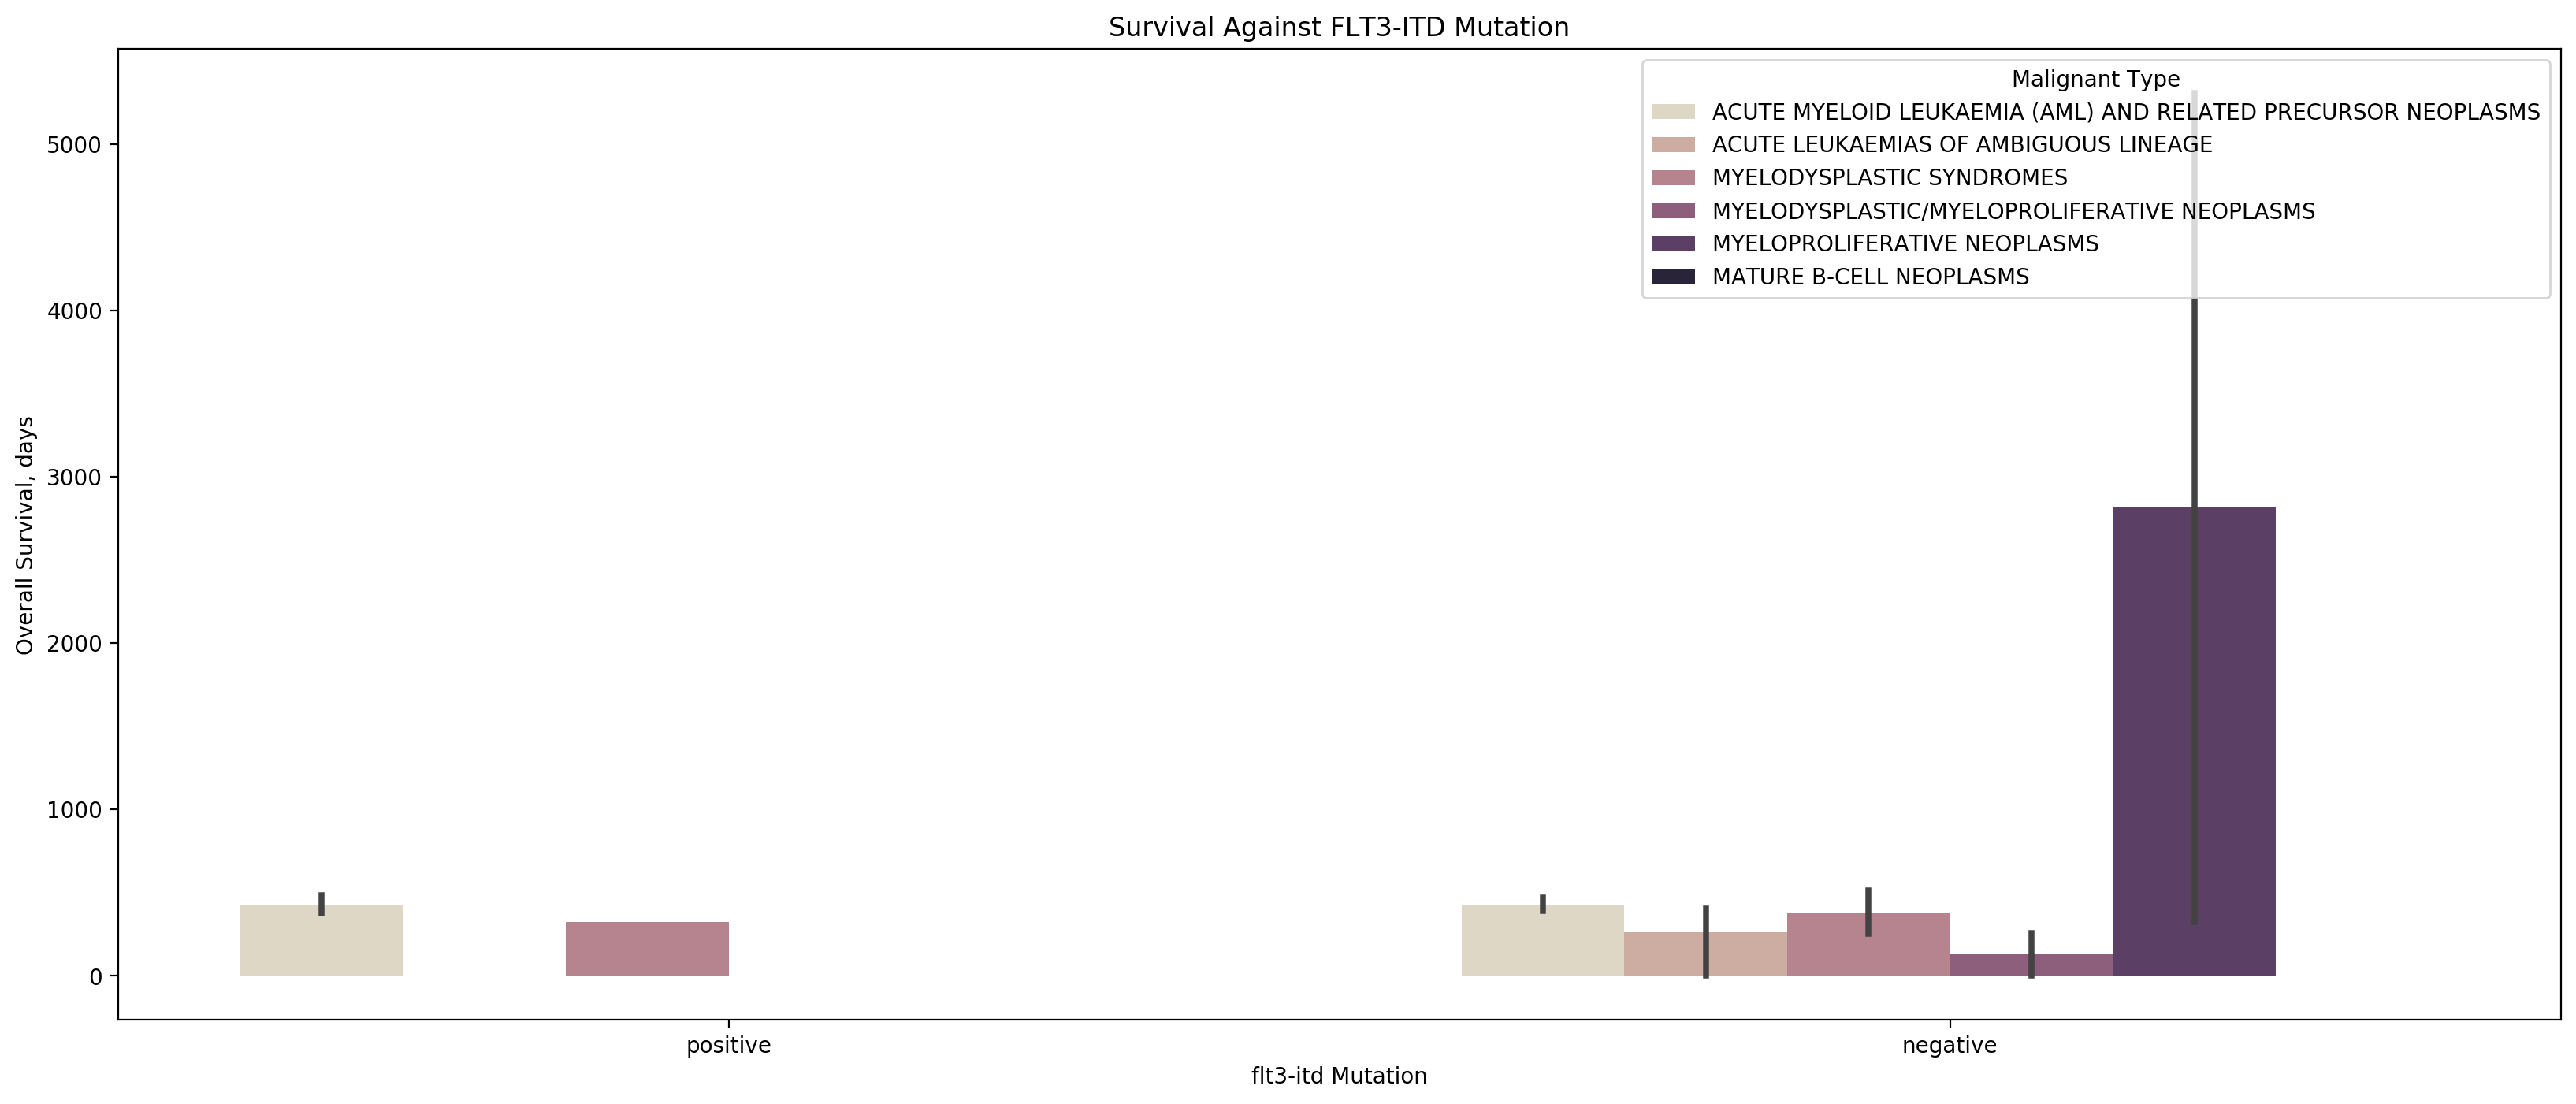

In [163]:
sns.barplot(data= clsm_cut,x = 'flt3-itd', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('flt3-itd Mutation')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against FLT3-ITD Mutation")

Text(0.5, 1.0, 'Survival Against Risk classification assigned to the Specimen based on European Leukemia Network 2017 guidelines')

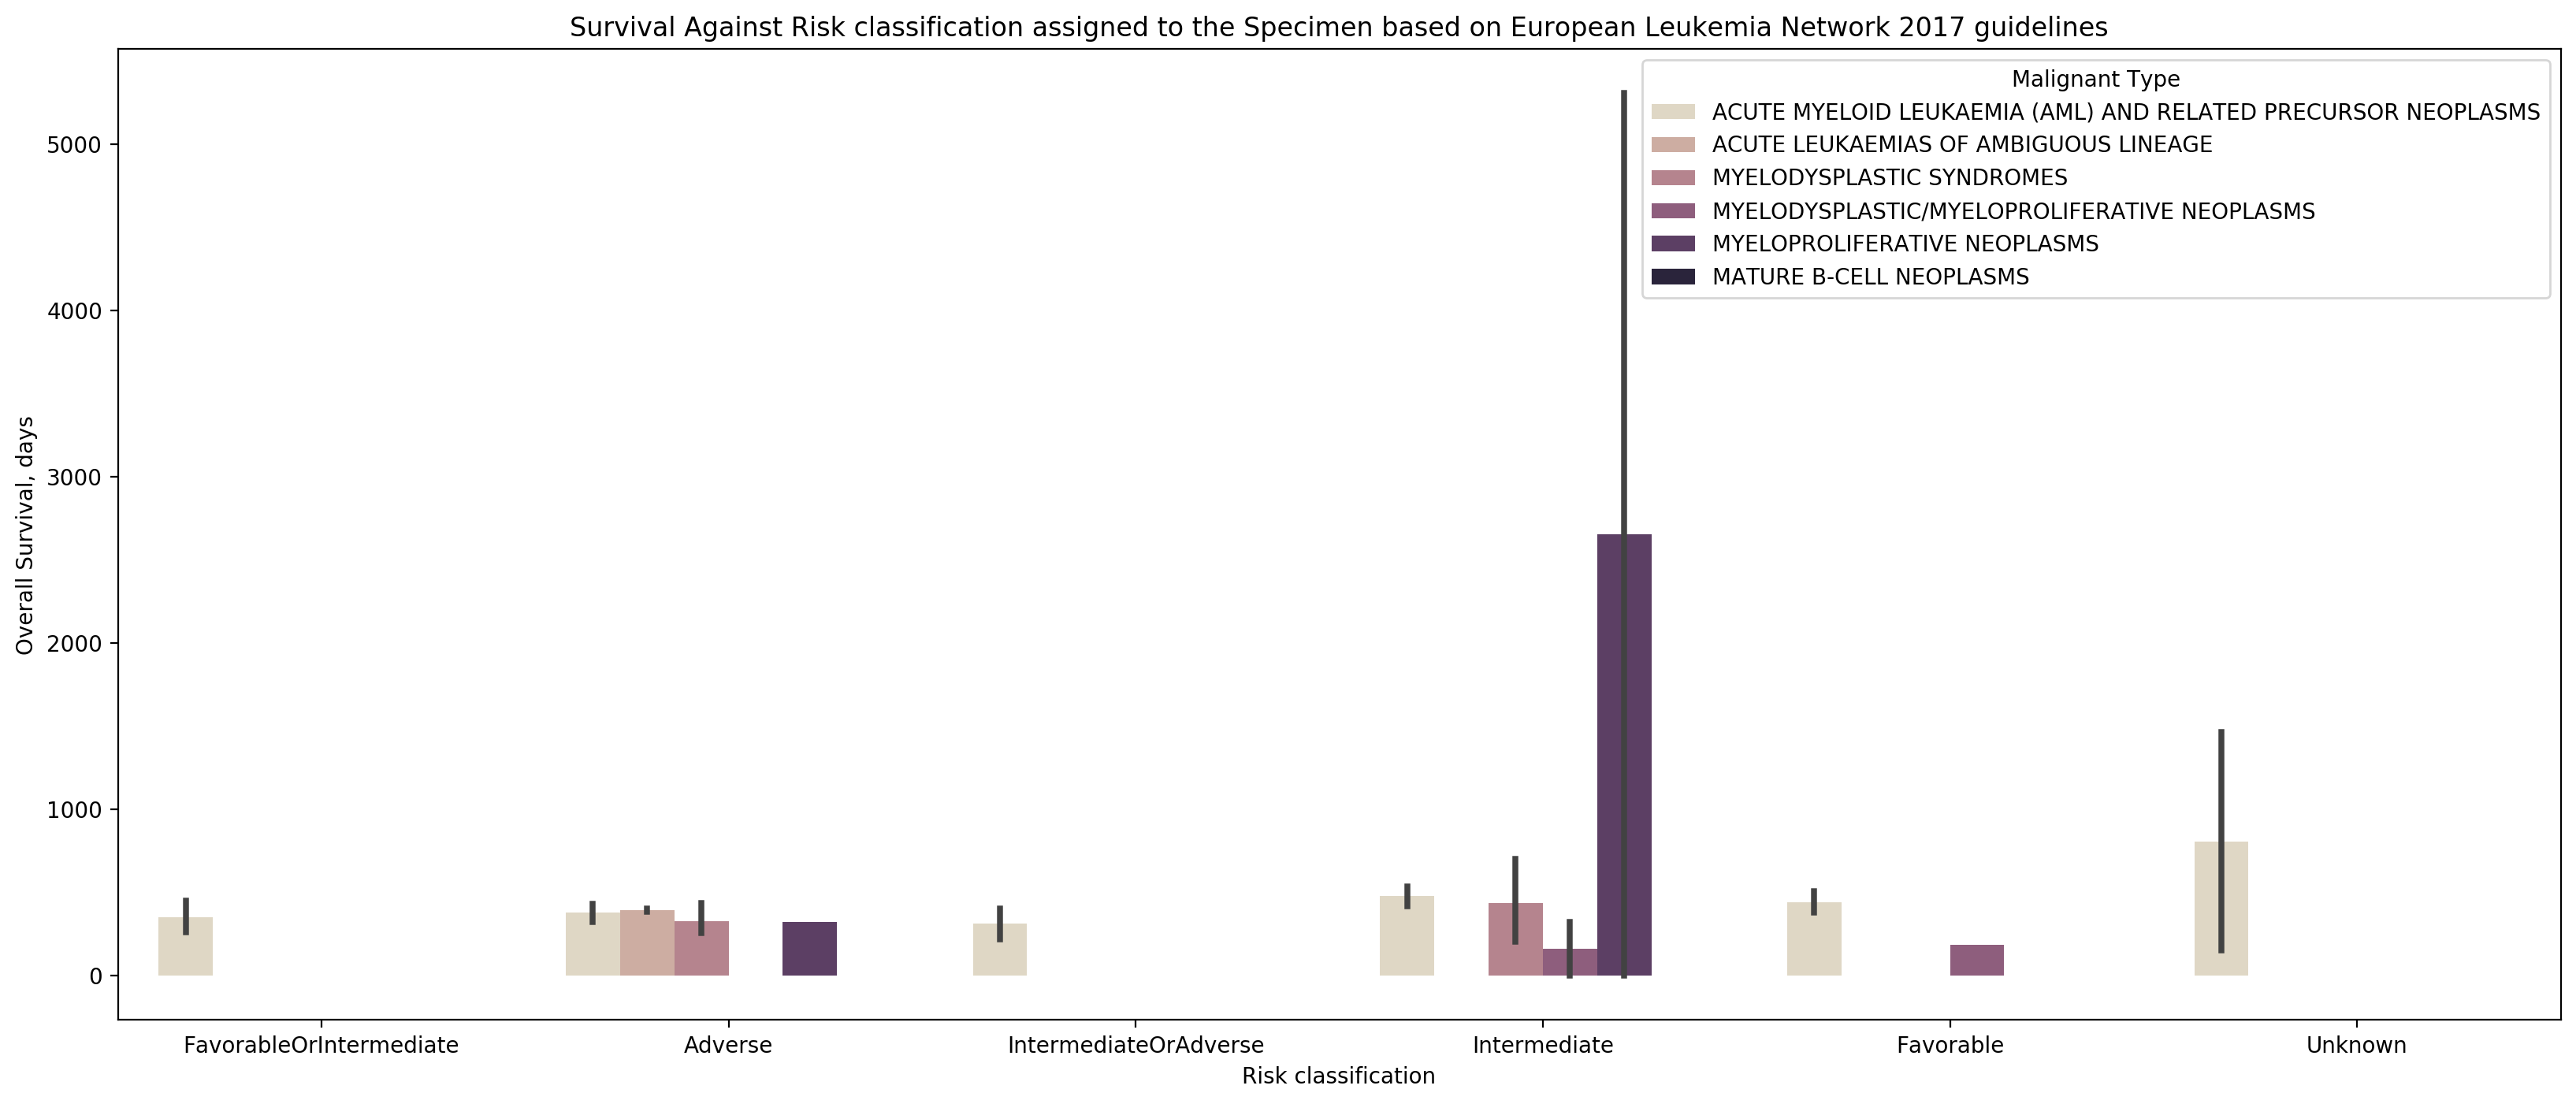

In [164]:
sns.barplot(data= clsm_cut,x = 'eln2017', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('Risk classification')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Risk classification assigned to the Specimen based on European Leukemia Network 2017 guidelines")

Text(0.5, 1.0, 'Survival Against Prior MDS Diagnosis')

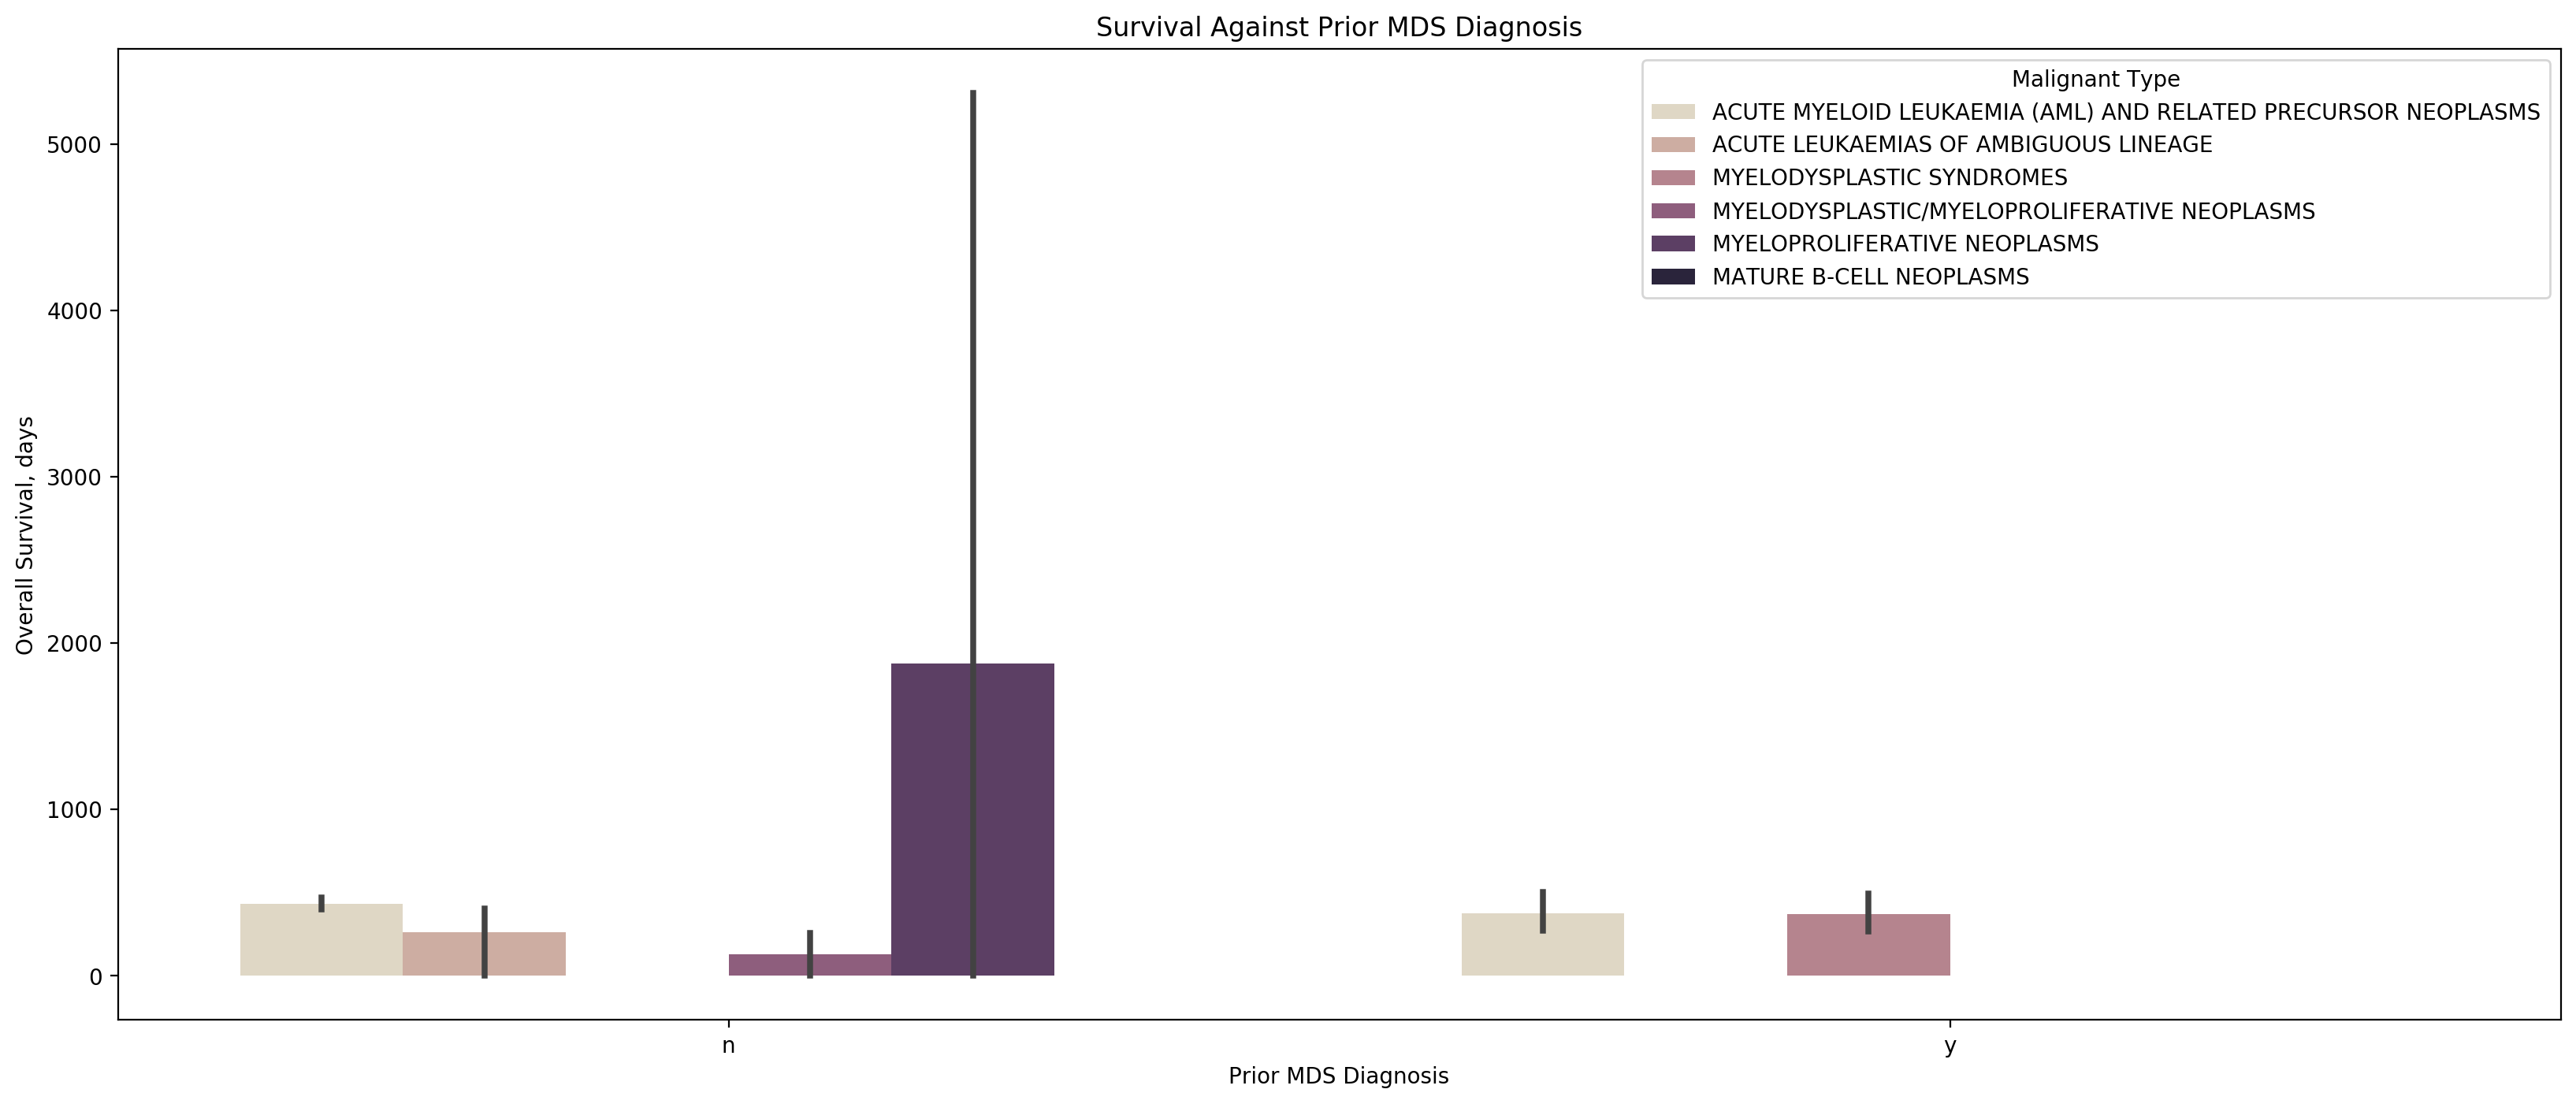

In [165]:
sns.barplot(data= clsm_cut,x = 'priormds', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('Prior MDS Diagnosis')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Prior MDS Diagnosis")

Text(0.5, 1.0, 'Survival Against Prior MDS and MPN Diagnosis')

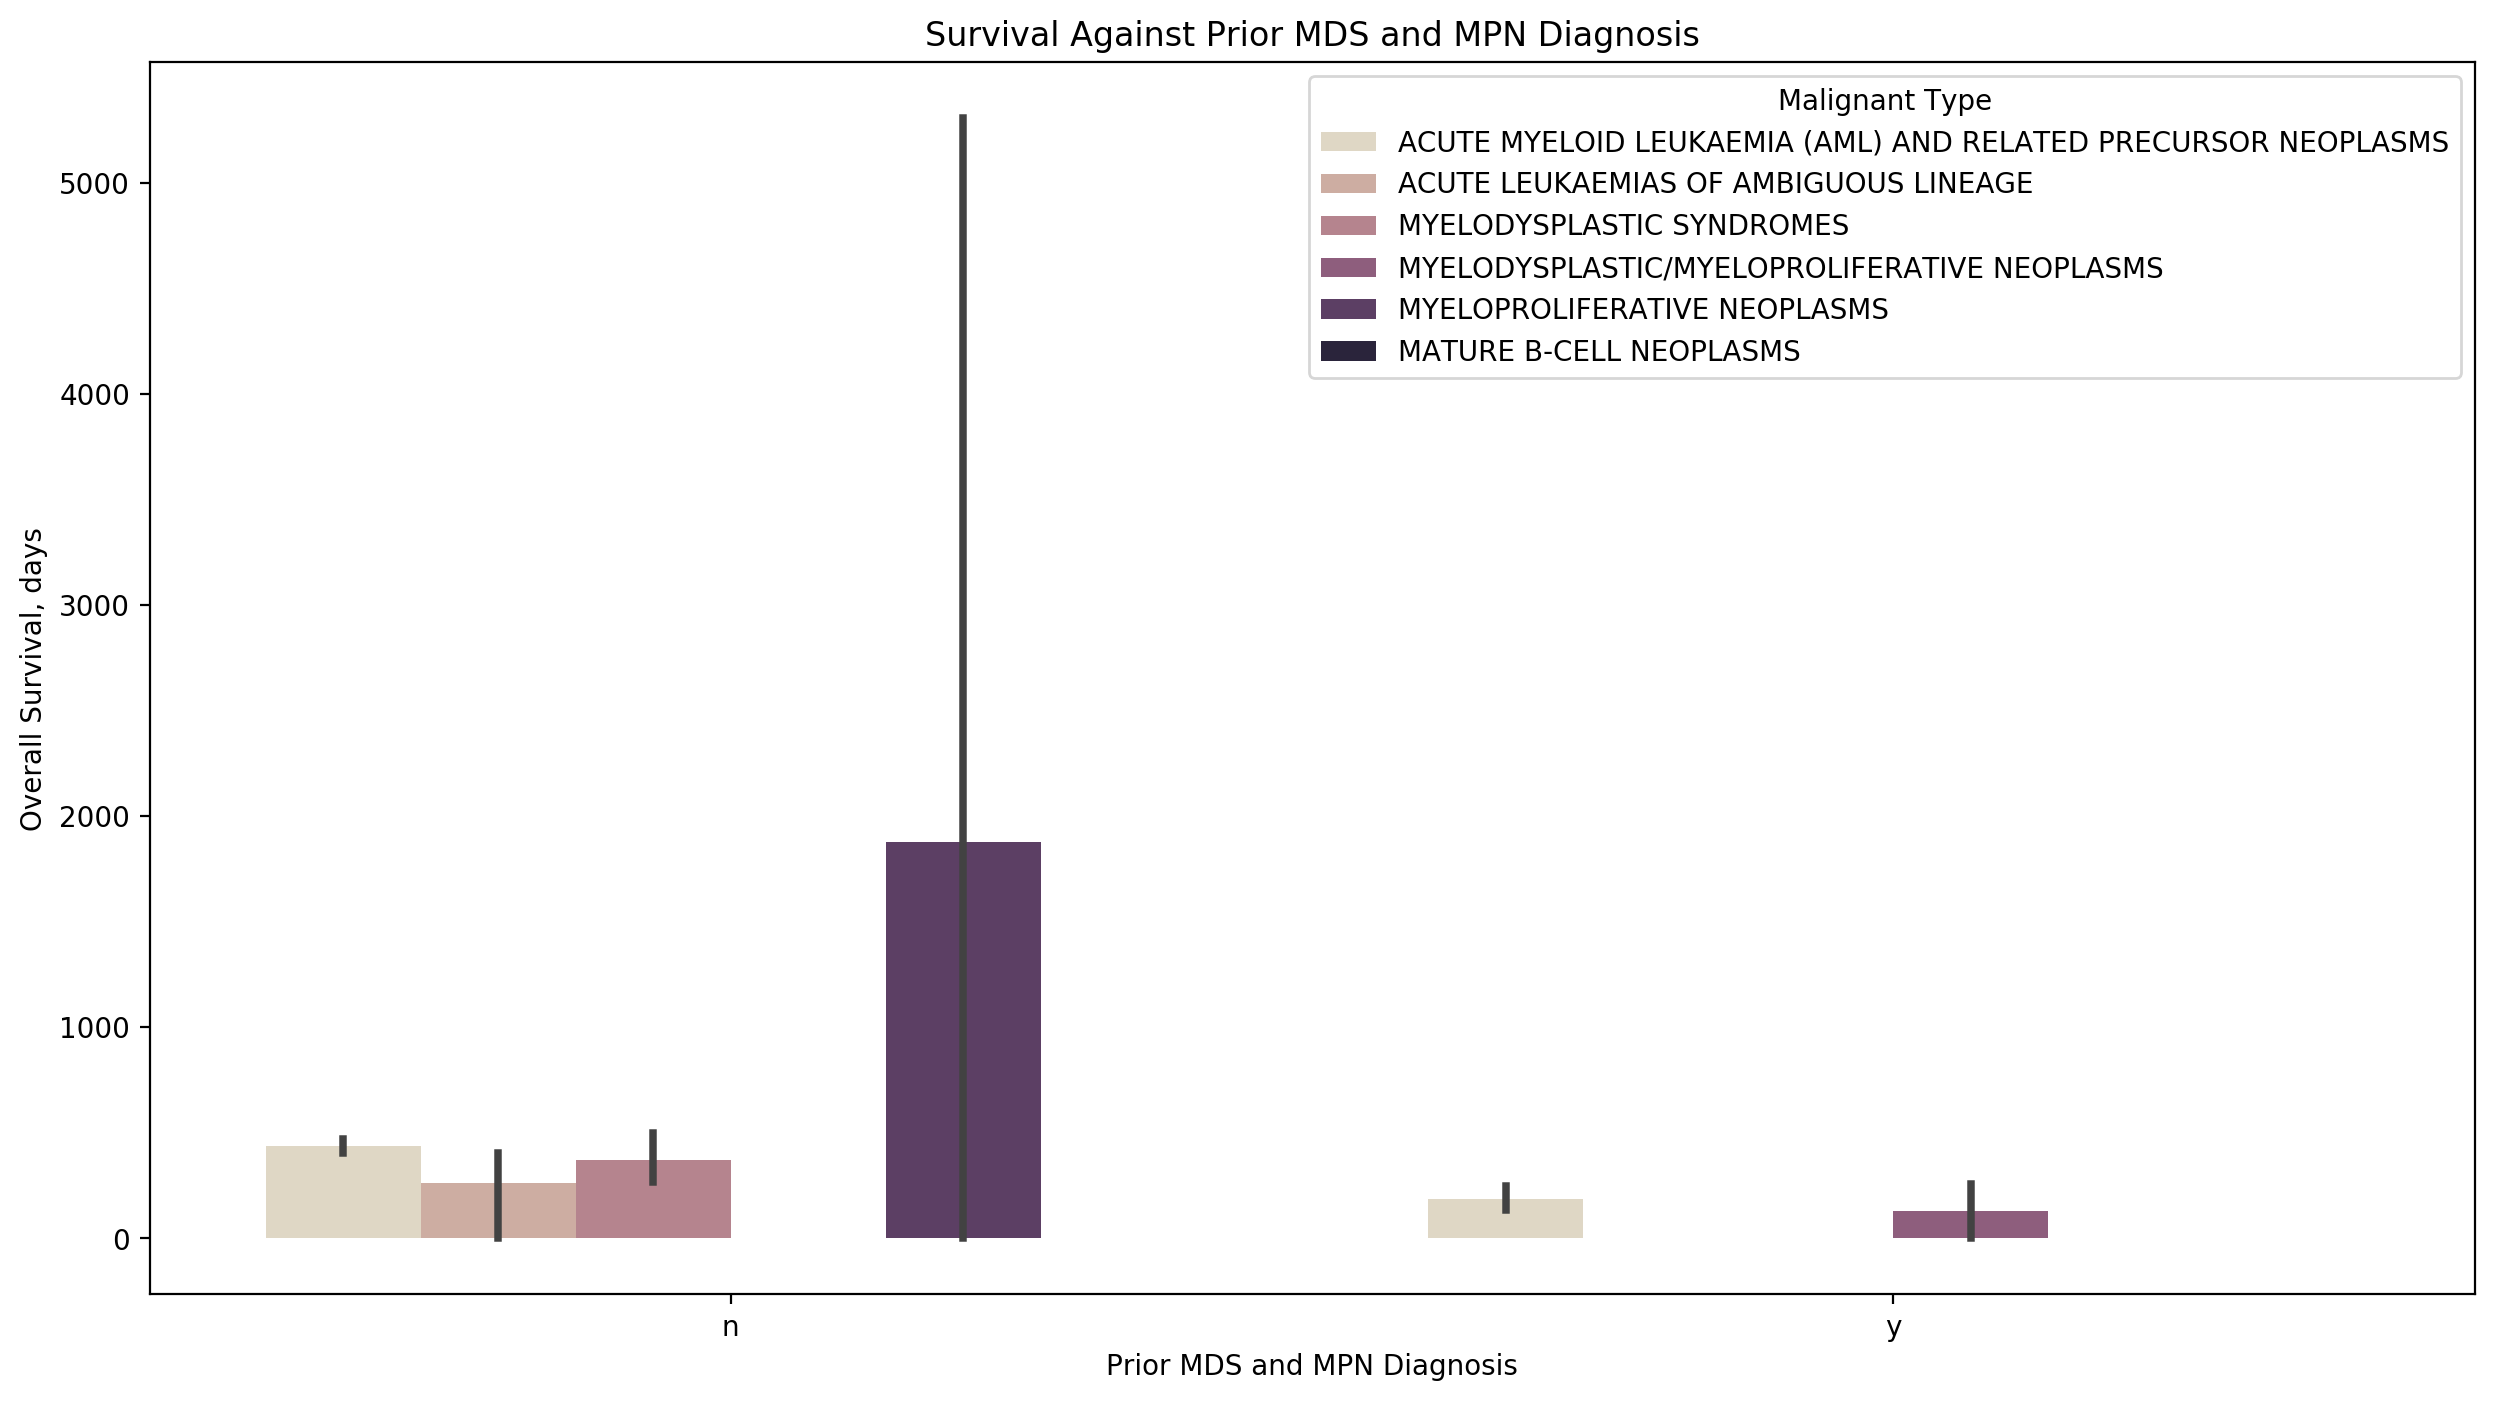

In [166]:
sns.barplot(data= clsm_cut,x = 'priormdsmpn', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(15, 8)
plt.xlabel('Prior MDS and MPN Diagnosis')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Prior MDS and MPN Diagnosis")

Text(0.5, 1.0, 'Survival Against Prior MPN Diagnosis')

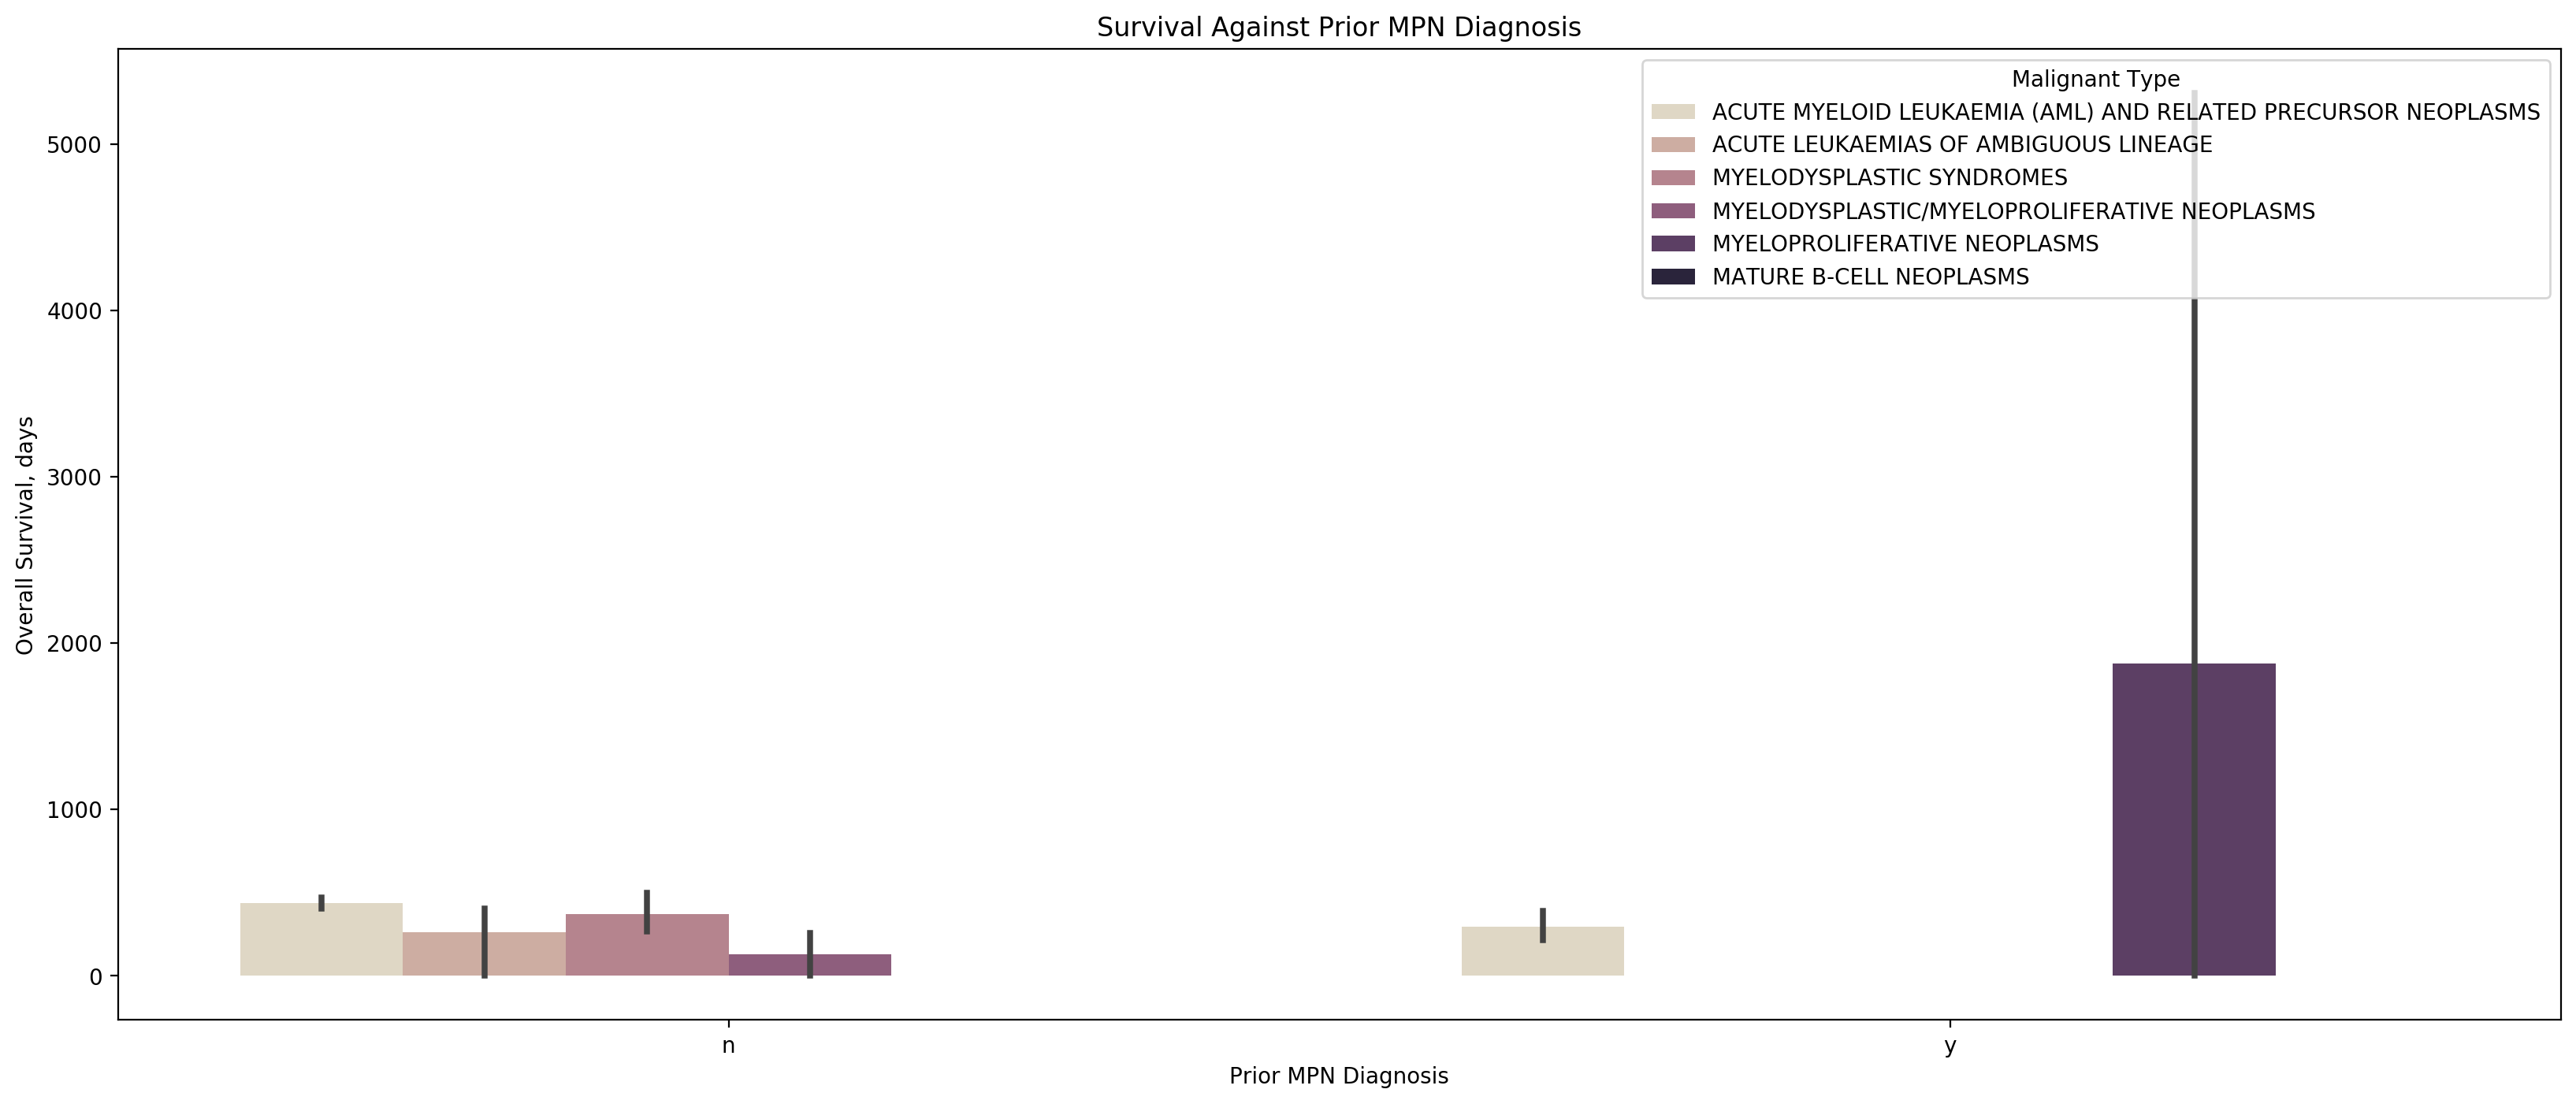

In [167]:
sns.barplot(data= clsm_cut,x = 'priormpn', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('Prior MPN Diagnosis')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Prior MPN Diagnosis")

Text(0.5, 1.0, '%Blast in Peripheral Blood against Prior NPM1 Mutation')

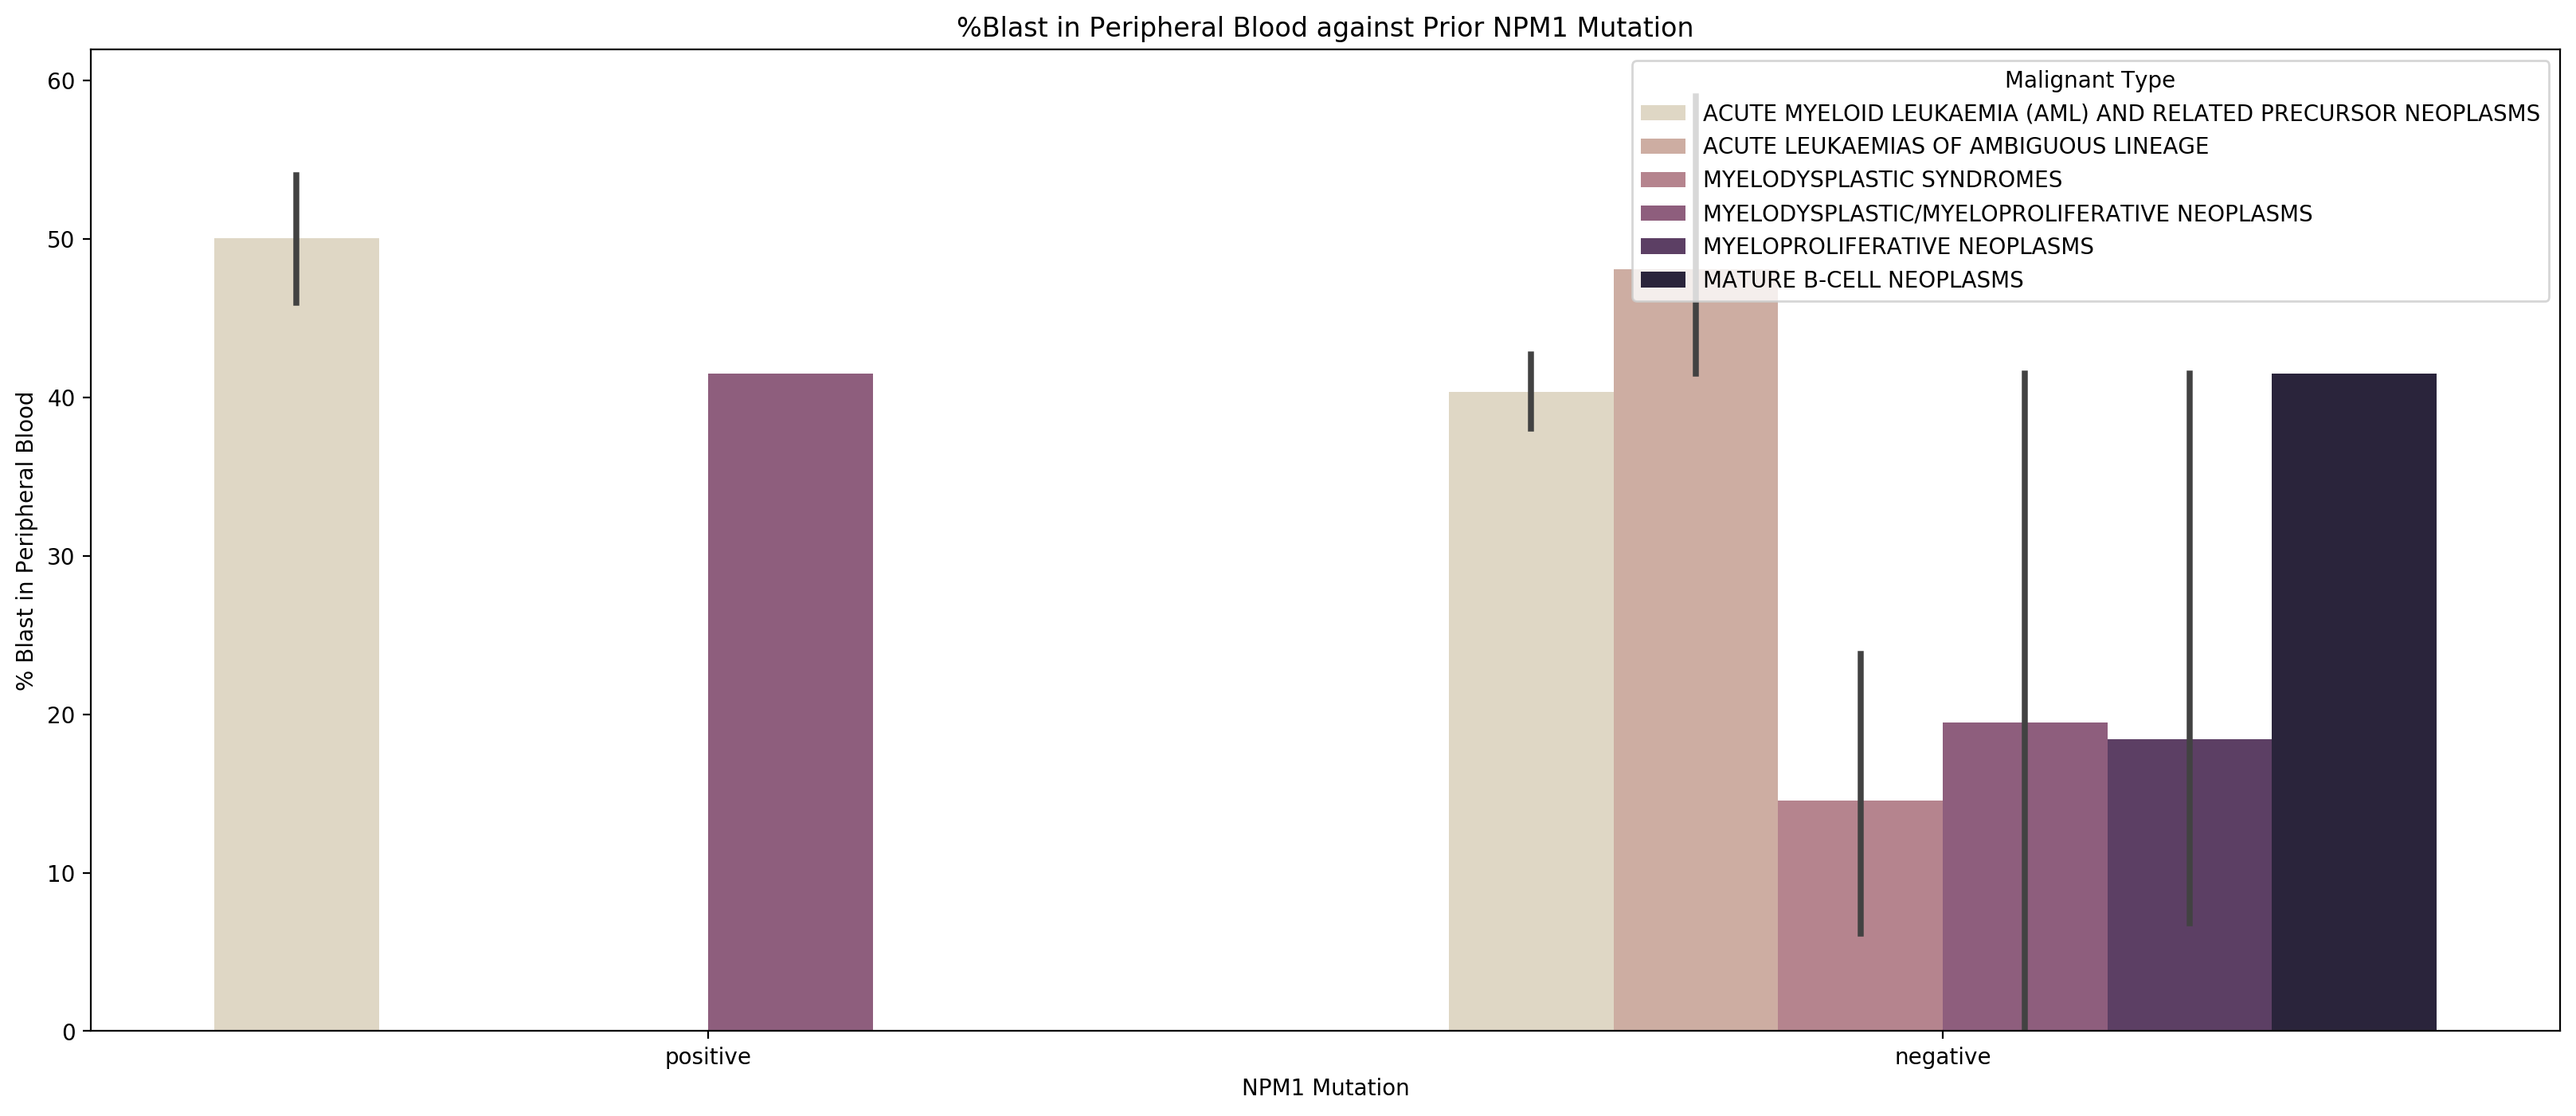

In [168]:
sns.barplot(data= clsm_cut,x = 'npm1', y = '%.blasts.in.pb', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('NPM1 Mutation')
plt.ylabel('% Blast in Peripheral Blood')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("%Blast in Peripheral Blood against Prior NPM1 Mutation")

Text(0.5, 1.0, '%Blast in Bone Marrow Against NPM1 Mutation')

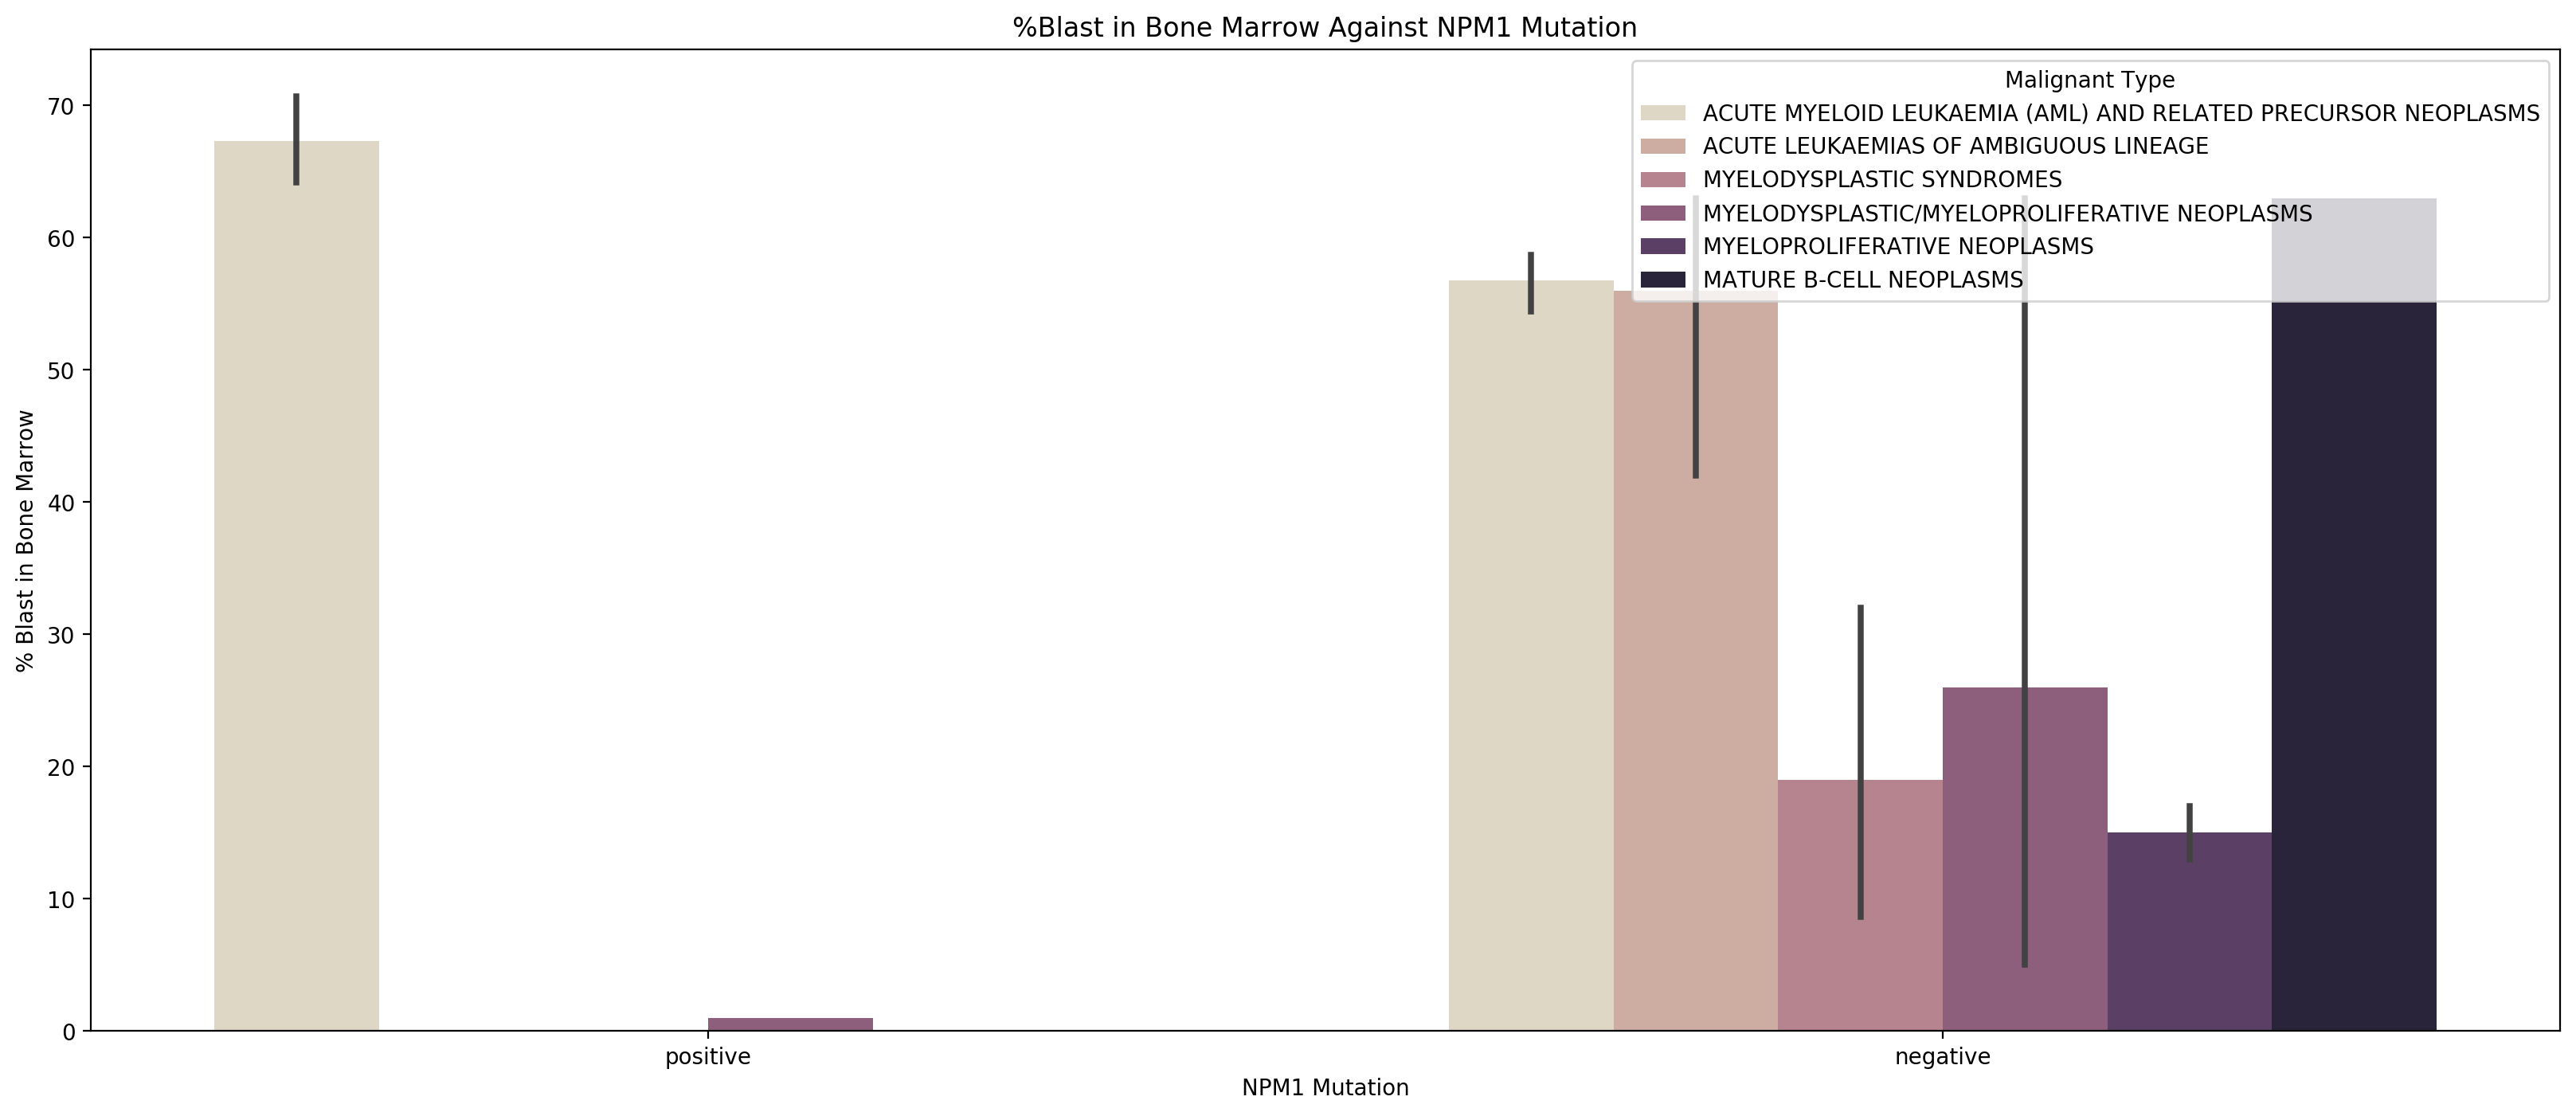

In [169]:
sns.barplot(data= clsm_cut,x = 'npm1', y = '%.blasts.in.bm', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('NPM1 Mutation')
plt.ylabel('% Blast in Bone Marrow')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("%Blast in Bone Marrow Against NPM1 Mutation")

Text(0.5, 1.0, '%Blast in Peripheral Blood against Prior NPM1 Mutation')

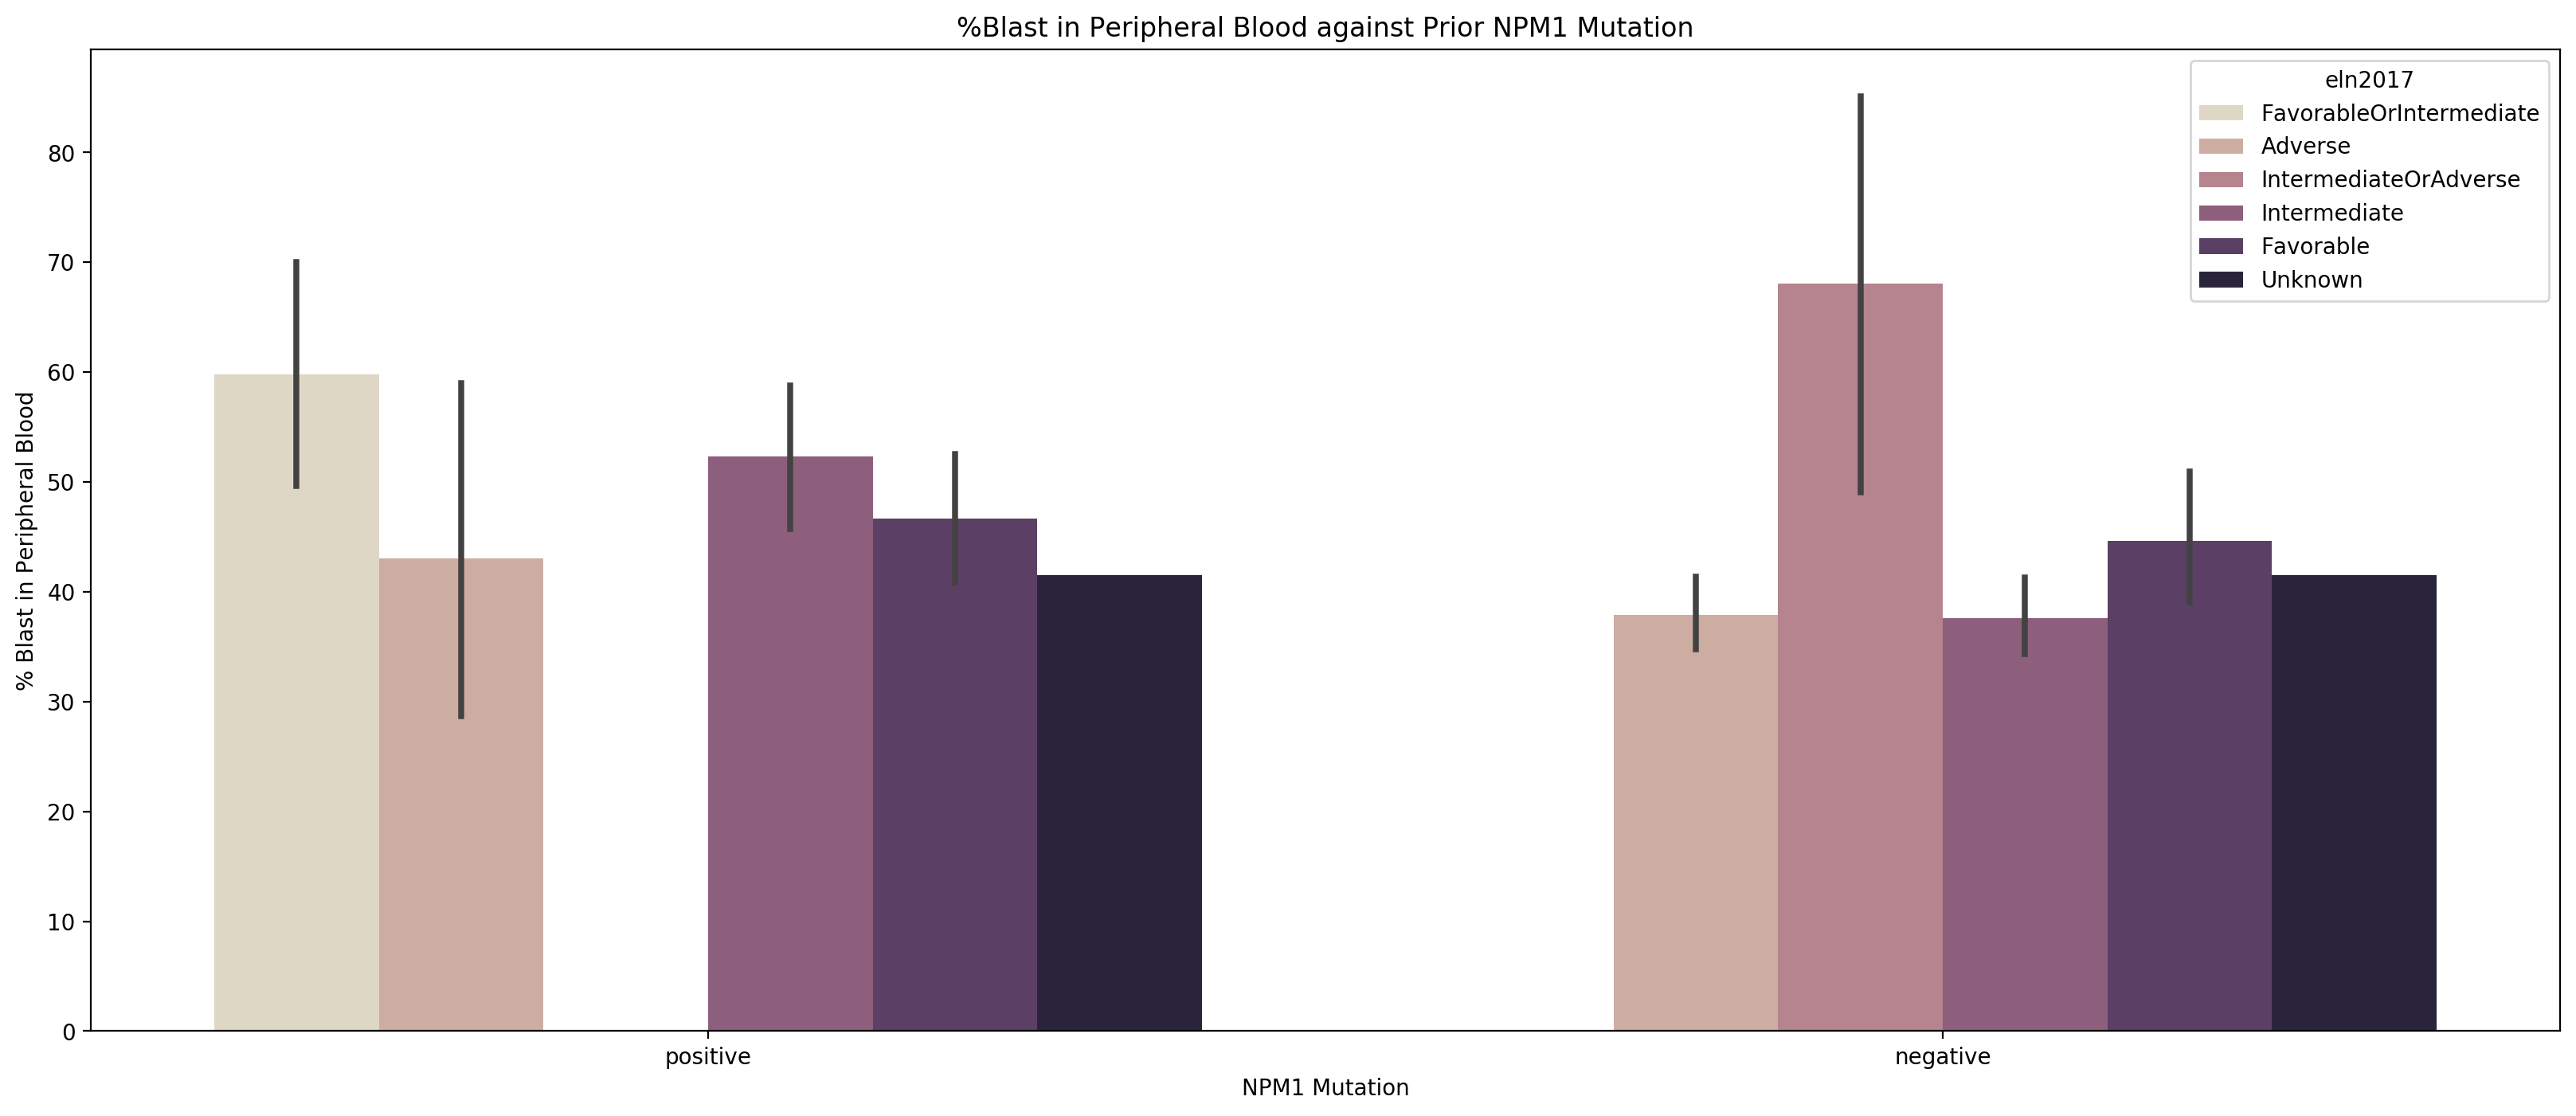

In [170]:
sns.barplot(data= clsm_cut,x = 'npm1', y = '%.blasts.in.pb', 
            hue = 'eln2017', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('NPM1 Mutation')
plt.ylabel('% Blast in Peripheral Blood')
plt.legend(loc='upper right', title = 'eln2017')
plt.title("%Blast in Peripheral Blood against Prior NPM1 Mutation")

Text(0.5, 1.0, '%Blast in Bone Marrow Against NPM1 Mutation')

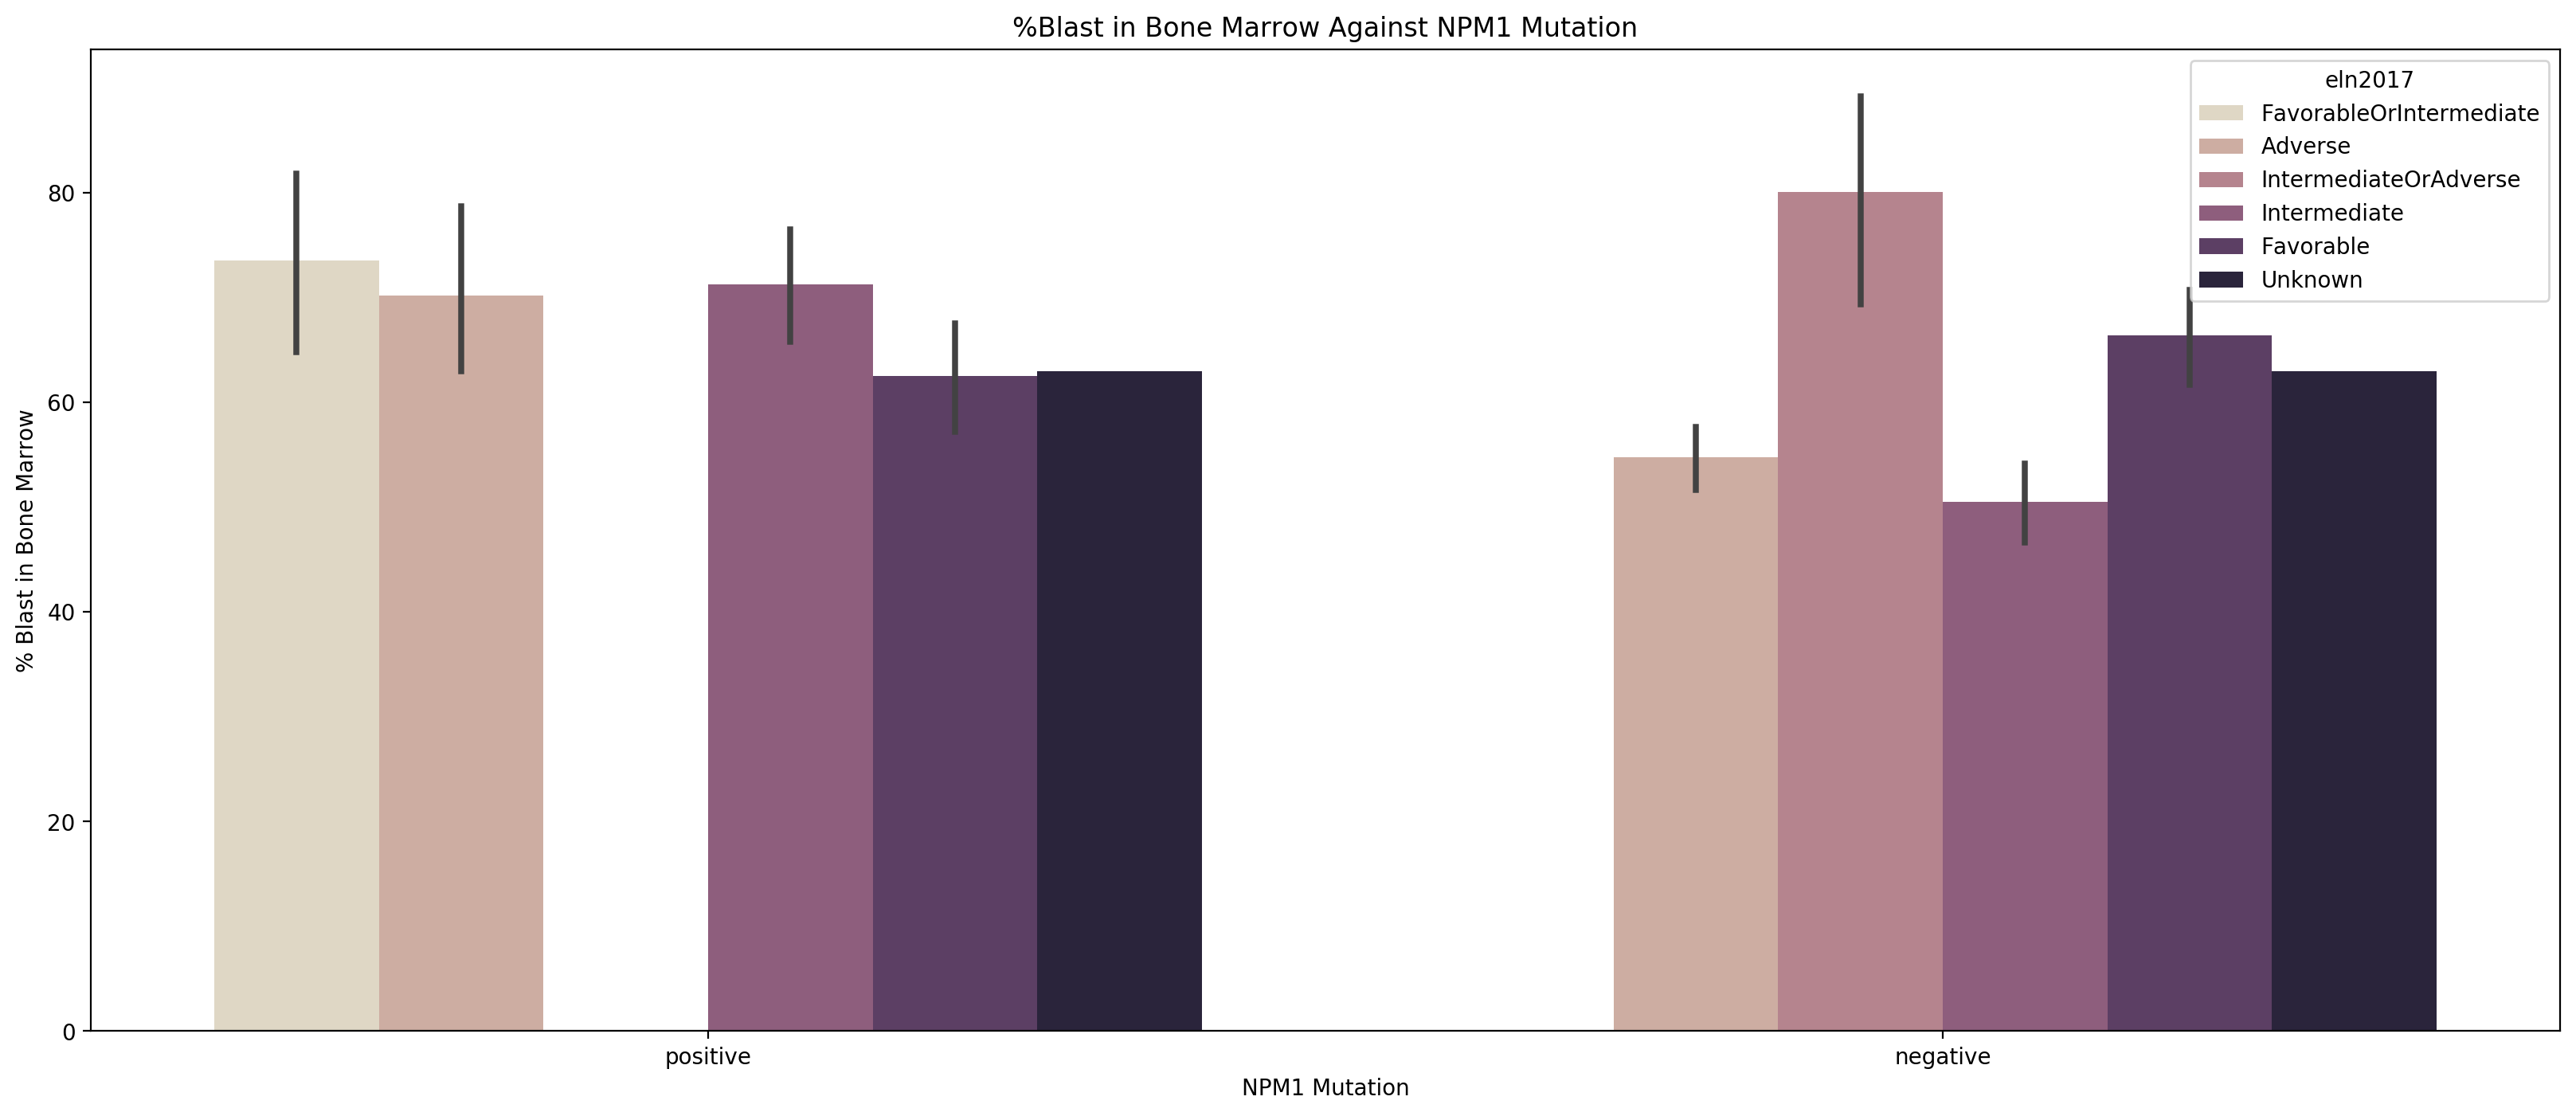

In [172]:
sns.barplot(data= clsm_cut,x = 'npm1', y = '%.blasts.in.bm', 
            hue = 'eln2017', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('NPM1 Mutation')
plt.ylabel('% Blast in Bone Marrow')
plt.legend(loc='upper right', title = 'eln2017')
plt.title("%Blast in Bone Marrow Against NPM1 Mutation")

# Release Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}